---
layout: post
title:  "Forward Modelling for Supernova Cosmology"
desc: "A toy model implementation"
date: 2020-04-08
categories: [tutorial]
tags: [bayesian]
loc: 'tutorials/forwardmodelling/'
permalink: /tutorials/forwardmodelling
math: true
---

!!!replace

So in this example, I'm simply trying to demonstrate the viability of forward models with supernova cosmology. In this, I'll be simplifying a lot, and in this case, ignoring contributions from Monte-Carlo uncertainty. We'll start with a simple one dimensional model in only $\Omega_m$ and magnitude only scatter, but then add in colour populations.



In [124]:
# Remove
import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['figure.dpi'] = 250
plt.rcParams['hist.bins'] = 50
plt.rcParams['lines.markersize'] = 2
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = (cycler(color=['#48AB75',  '#5BC0EB', '#E55934', '#FA7921', '#ced9ed', '#fff29b']) + cycler(linestyle=['-', '-', ':', '-.', '-', '--']))

## Generating Data

First things first - lets generate some random data in a horrifically simplified toy model.

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, uniform
from astropy.cosmology import FlatLambdaCDM
from scipy.stats import binned_statistic

np.random.seed(0)
def get_events(om=0.3, MB=-19.3, sigma_int=0.1, num=3000):
    zs = np.linspace(0.05, 1.05, num)   
    
    # Do many realistions and pick one which should center our cosmology contours on the truth
    # instead of having it follow the expected scatter
    bins = 100
    n = int(num / bins)
    deltas = np.array([])
    for i in range(bins):
        cdfs = norm.cdf(norm.rvs(size=2 * n))
        maxv = cdfs.max()
        delta = norm.ppf(np.linspace(1 - maxv, maxv, n)) * sigma_int
        np.random.shuffle(delta)
        deltas = np.concatenate((deltas, delta))

    MBs = MB + deltas
    distmod = FlatLambdaCDM(70, om).distmod(zs).value
    mb = distmod + MBs
    # Emulate some probabilistic selection effect
    mask = (mb + norm.rvs(scale=0.3, size=num)) < 24
    return mb[mask], zs[mask]

data_mbs, data_zs = get_events()

Now, let's plot our generated data to make sure it all looks good.

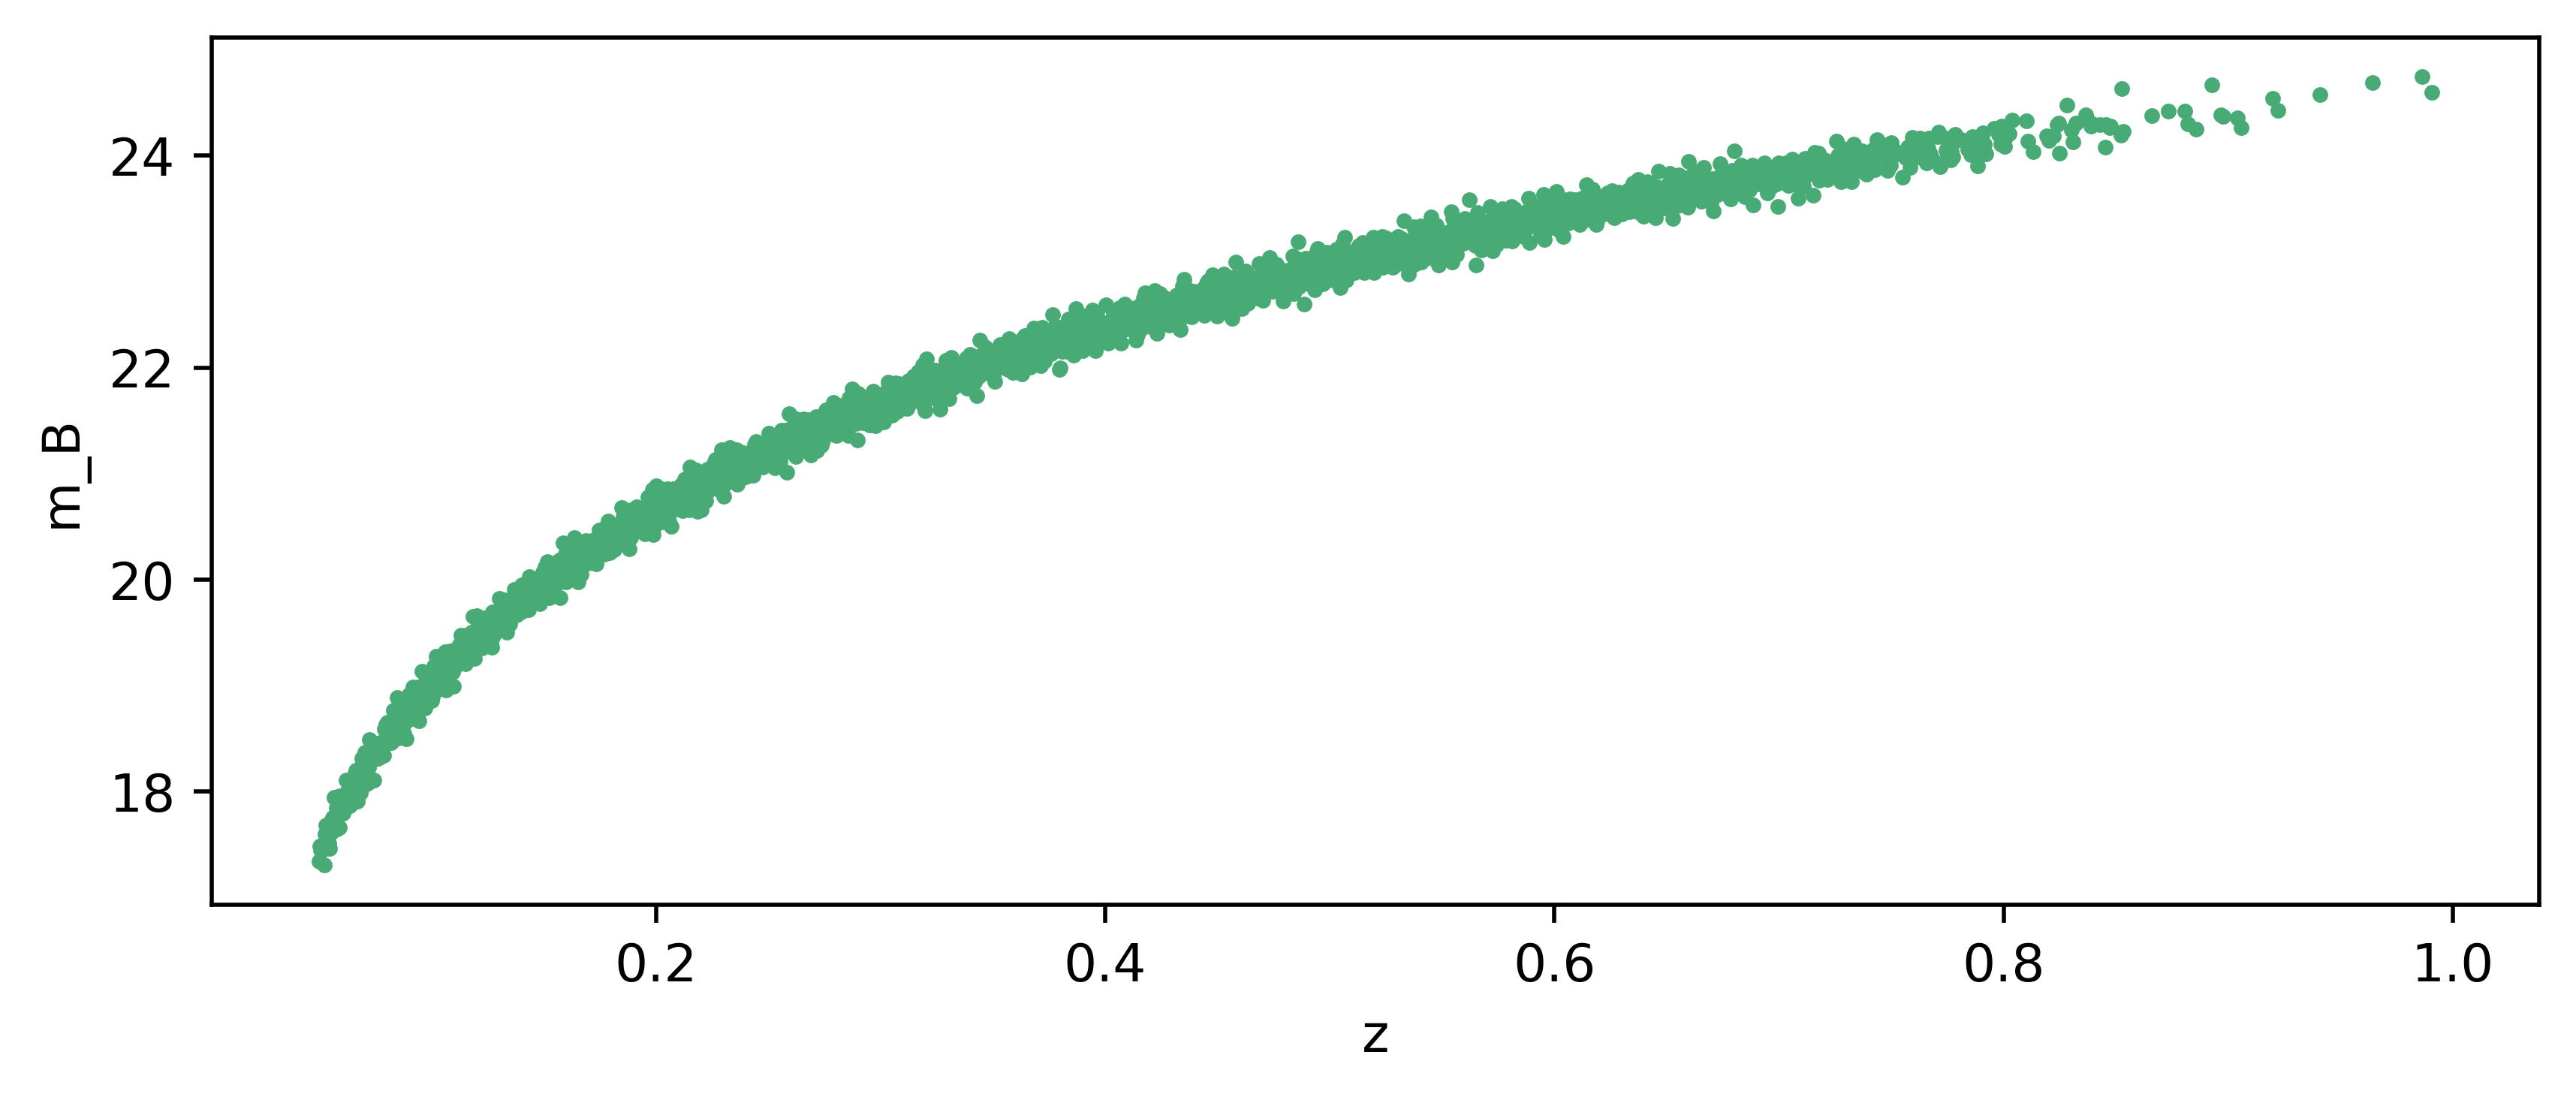

In [126]:
fig, ax = plt.subplots(figsize=(8,3))
ax.scatter(data_zs, data_mbs)
ax.set_xlabel("z"), ax.set_ylabel("m_B");

Great, so we have "data". If we want to fit it using some importance-sampling ABC method we need to:

1. Create a base simulation
2. Reweight the simulation base on top-level parameters like Om, MB, sigma_int.
3. Compare the data to the re-weighted simulation to get a likelihood.

In [127]:
def get_sim_events(num=100000):
    MBs = uniform.rvs(-21.3, 4, size=num)
    zs = 0.05 + uniform.rvs(size=num)
    # The value here for om doesnt actually matter. Let me delibrately set it 'wrong'
    distmod = FlatLambdaCDM(70, 0.3).distmod(zs).value
    mb = distmod + MBs
    # Emulate some probabilistic selection effect
    mask = (mb + norm.rvs(scale=0.3, size=num)) < 24
    return mb[mask], zs[mask]

sim_mbs, sim_zs = get_sim_events()

Lets check the spread of this broad simulation.

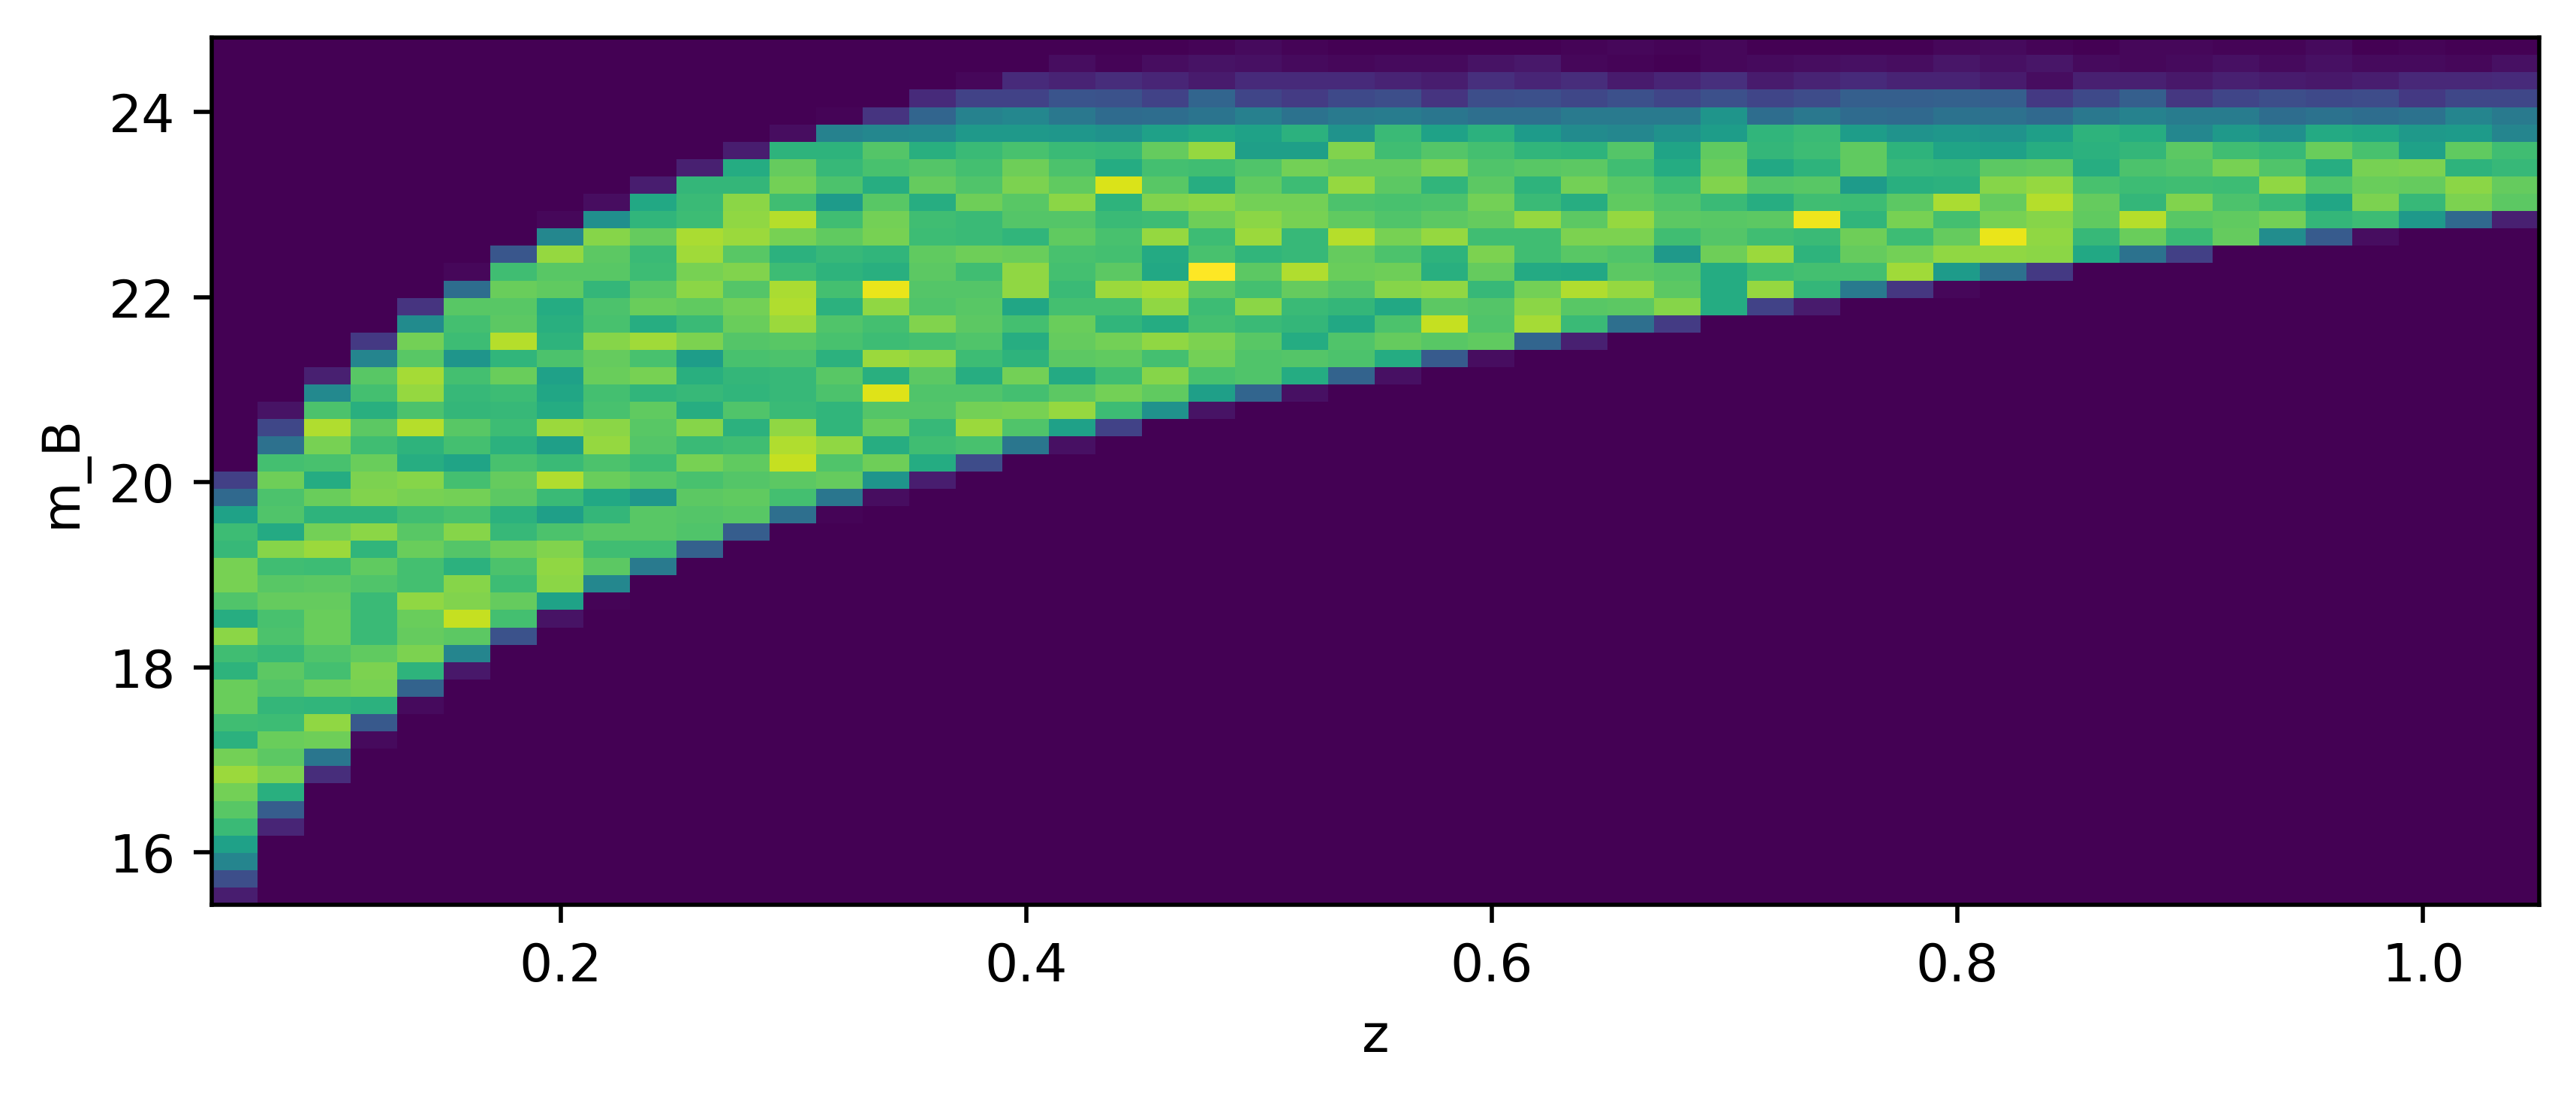

In [128]:
fig, ax = plt.subplots(figsize=(8,3))
ax.hist2d(sim_zs, sim_mbs, bins=50)
ax.set_xlabel("z"), ax.set_ylabel("m_B");

Hopefully, its broad enough. Now to reweight the simulation based on the top-level parameters.

In [129]:
def reweight(sim_mbs, sim_zs, om, MB, sigma_int):
    # Step 1: Use om to move from observer frame to rest frame
    distmod = FlatLambdaCDM(70, om).distmod(sim_zs).value
    sim_MBs = sim_mbs - distmod
    # Use top-level parameters to get pdf of simulation points
    weights = norm.pdf(sim_MBs, MB, sigma_int)
    return weights

Right, so we've got this, but it would be good if we could actually do some MCMC on this bad boy. Let's make a likelihood function. For simplicity in this notebook I'm going to break scope.

In [130]:
x_edges, y_edges = np.linspace(13, 26, 31), np.linspace(0.05, 1.05, 31)
xc, yc = 0.5 * (x_edges[:-1] + x_edges[1:]), 0.5 * (y_edges[:-1] + y_edges[1:])

thresh = 2
hist, _, _ = np.histogram2d(data_mbs, data_zs, bins=[x_edges, y_edges])
area = np.diff(x_edges)[0] * np.diff(y_edges)[0]
volume = hist.sum() * area
hist_err = np.sqrt(hist)
hist_err[hist_err < thresh] = np.inf

hist_err = hist_err / volume
hist = hist / volume

sim_count, _, _ = np.histogram2d(sim_mbs, sim_zs, [x_edges, y_edges])
sim_num_err = np.sqrt(sim_count)
sim_num_err[sim_num_err < thresh] = np.inf
sim_err_ratio = sim_num_err / sim_count
sim_err_ratio[sim_count == 0] = np.inf


def get_chi2(x, plot=False):
    om, MB, sigma_int = x
    # Add a prior onto MB to help fitting

    weights = reweight(sim_mbs, sim_zs, om, MB, sigma_int)
    # Now need a likelihood combining data and simulation. This is super simple, we'd probably 
    # want something like 1712.01293 in a real analysis where we combine MC and Poisson uncert.
    sim_hist, _, _ = np.histogram2d(sim_mbs, sim_zs, [x_edges, y_edges], weights=weights, density=True)
    sim_err = sim_hist * sim_err_ratio
    if plot:
        plt.pcolormesh(xc, yc, hist)
        plt.colorbar()
        plt.title("data")
        plt.show()
        plt.pcolormesh(xc, yc, sim_hist)
        plt.colorbar()
        plt.title("sim")
        plt.show()
        plt.pcolormesh(xc, yc, sim_hist - hist)
        plt.colorbar()
        plt.title("diff")
        plt.show()
        plt.pcolormesh(xc, yc, ((sim_hist - hist)**2 / np.sqrt(hist_err**2 + sim_err**2)))
        plt.colorbar()
        plt.title("chi2")
        plt.show()
        plt.pcolormesh(xc, yc, hist_err)
        plt.colorbar()
        plt.title("hist err")
        plt.show()
        plt.pcolormesh(xc, yc, sim_err)
        plt.colorbar()
        plt.title("sim err")
        plt.show()
    chi2 = ((sim_hist - hist)**2 / (hist_err**2 + sim_err**2))
    chi2 = np.nan_to_num(chi2, copy=False).sum()
    if np.isnan(chi2):
        print(x)
    return chi2

def get_log_likelihood(x):
    om, MB, sigma_int = x
    if not 0.05 < om < 0.5:
        return -np.inf
    if not 0 < sigma_int < 1:
        return -np.inf
    if not -21.3 < MB < -17.3:
        return -np.inf
    prior = norm.logpdf(MB, -19.3, 1)
    val = -0.5 * get_chi2(x) + prior
    if np.isnan(val):
        return -np.inf
    return val
    

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


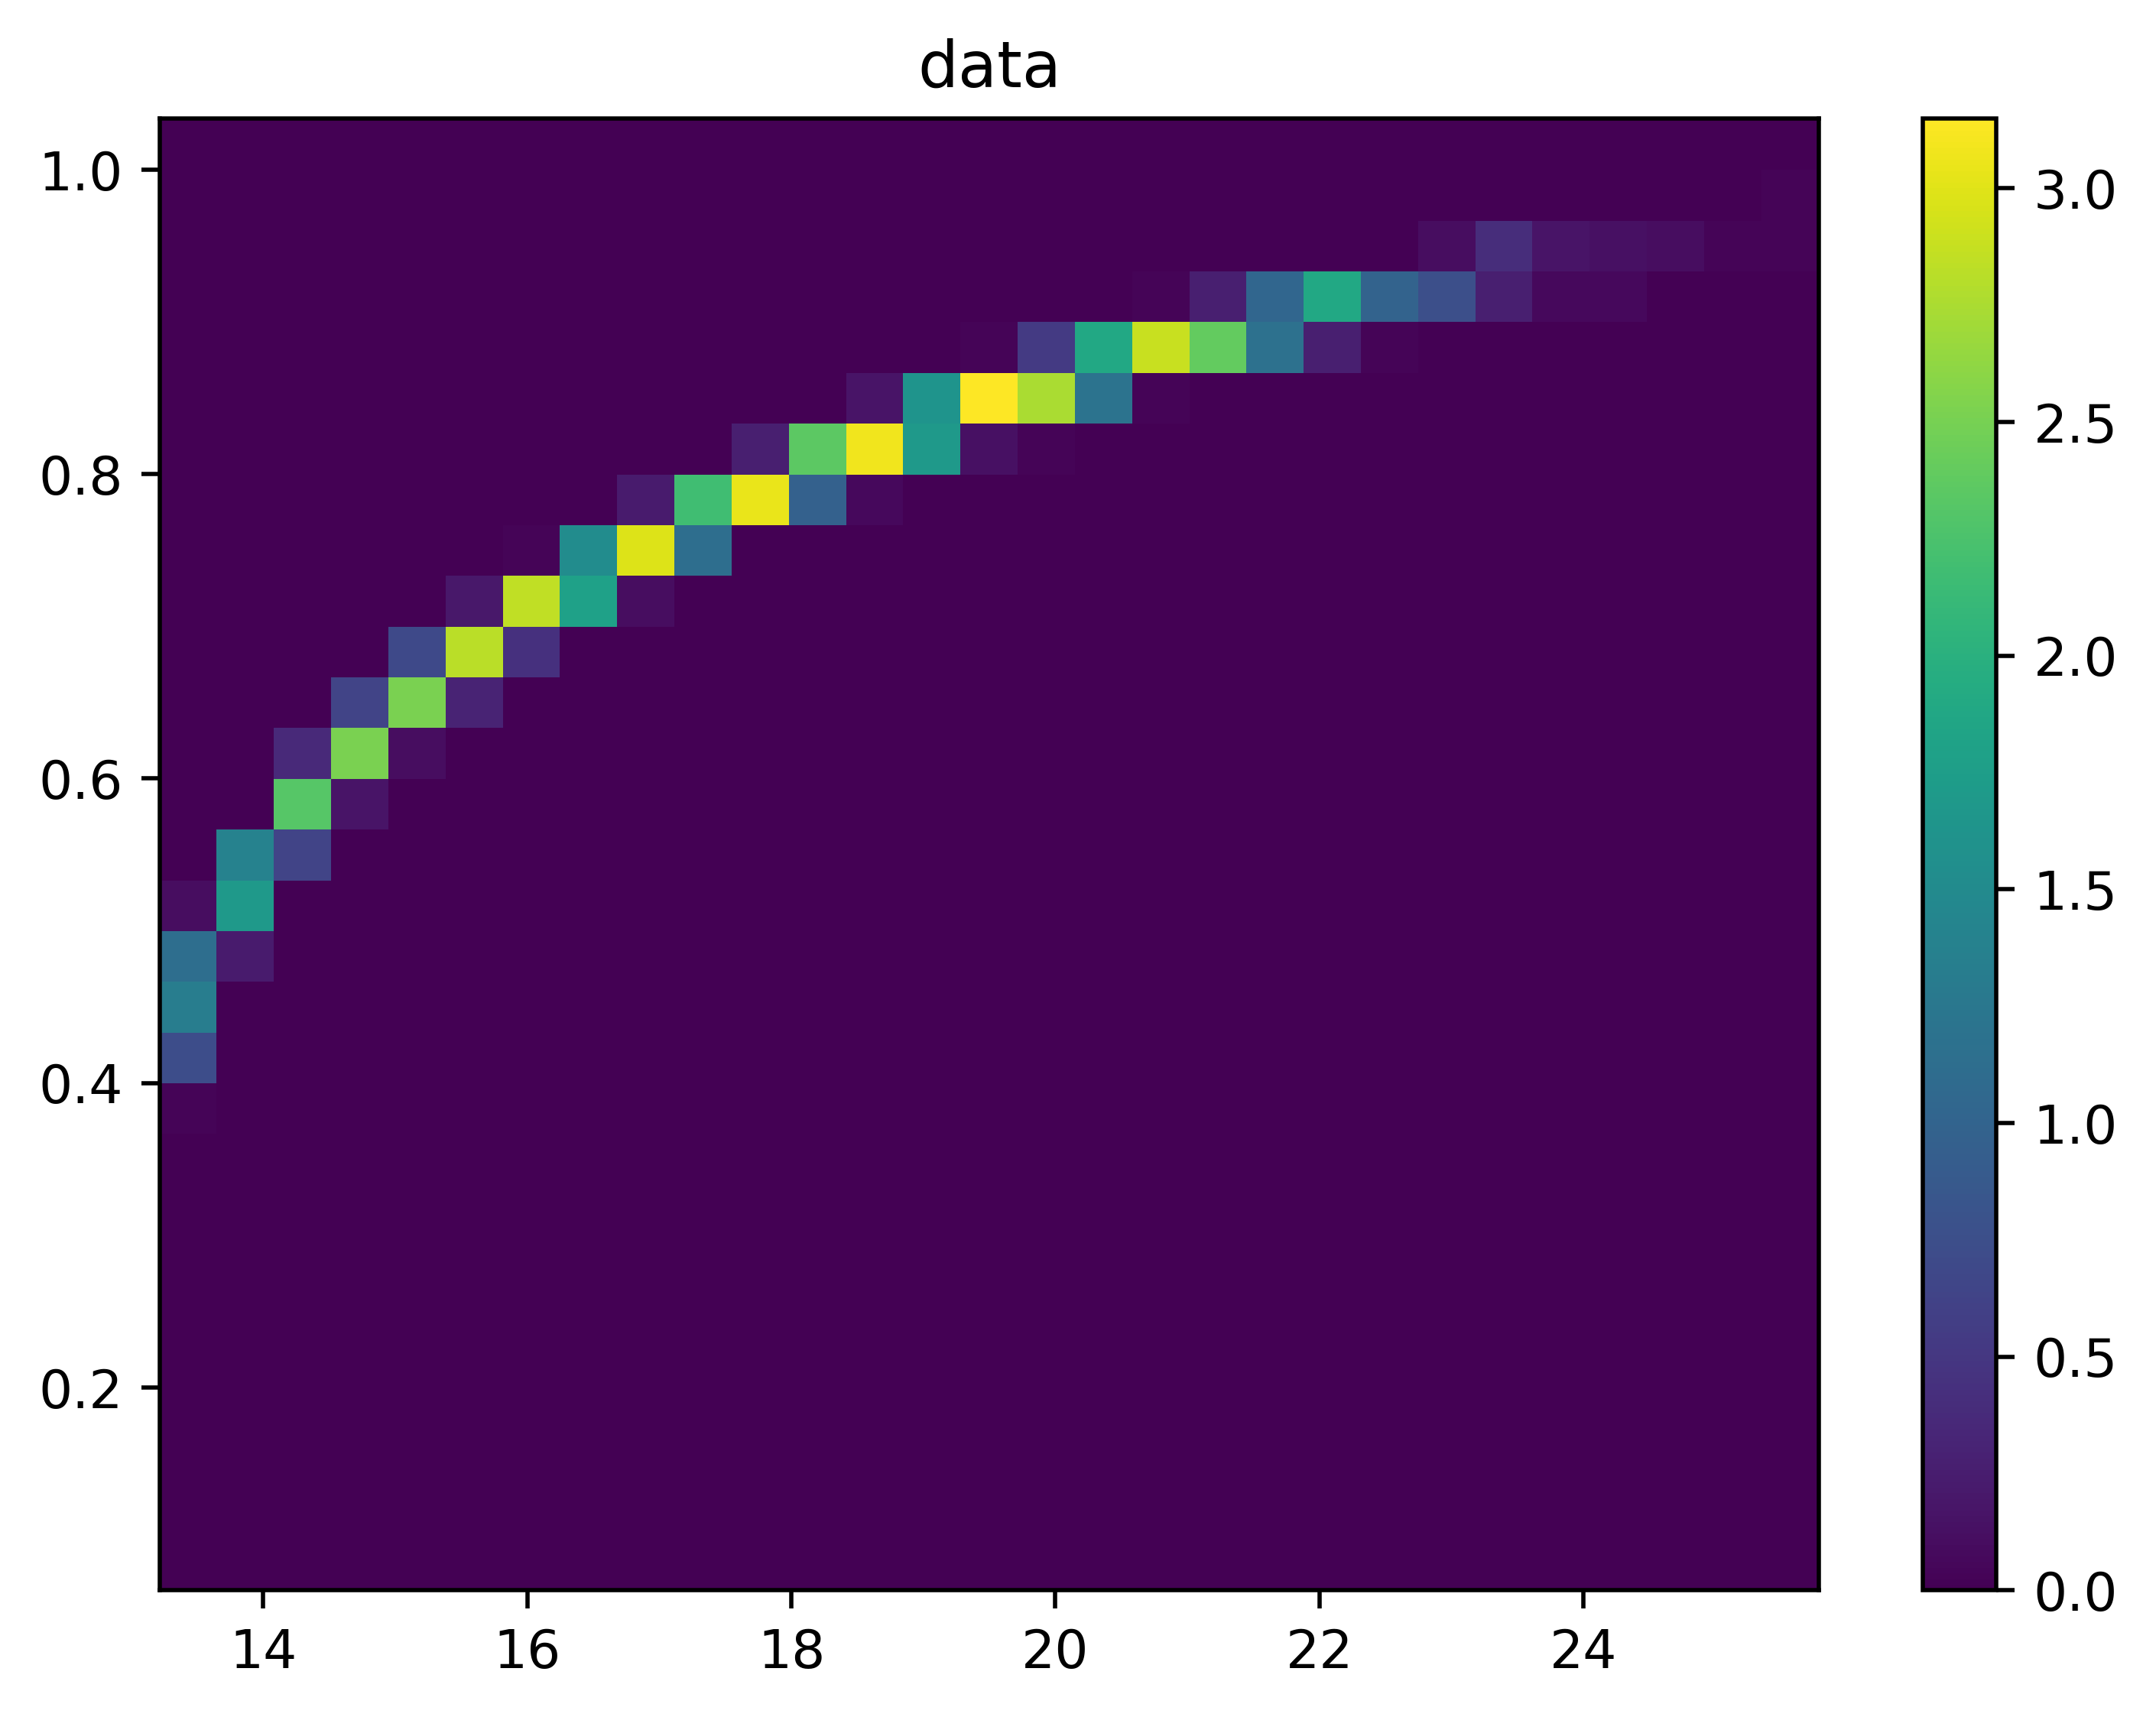

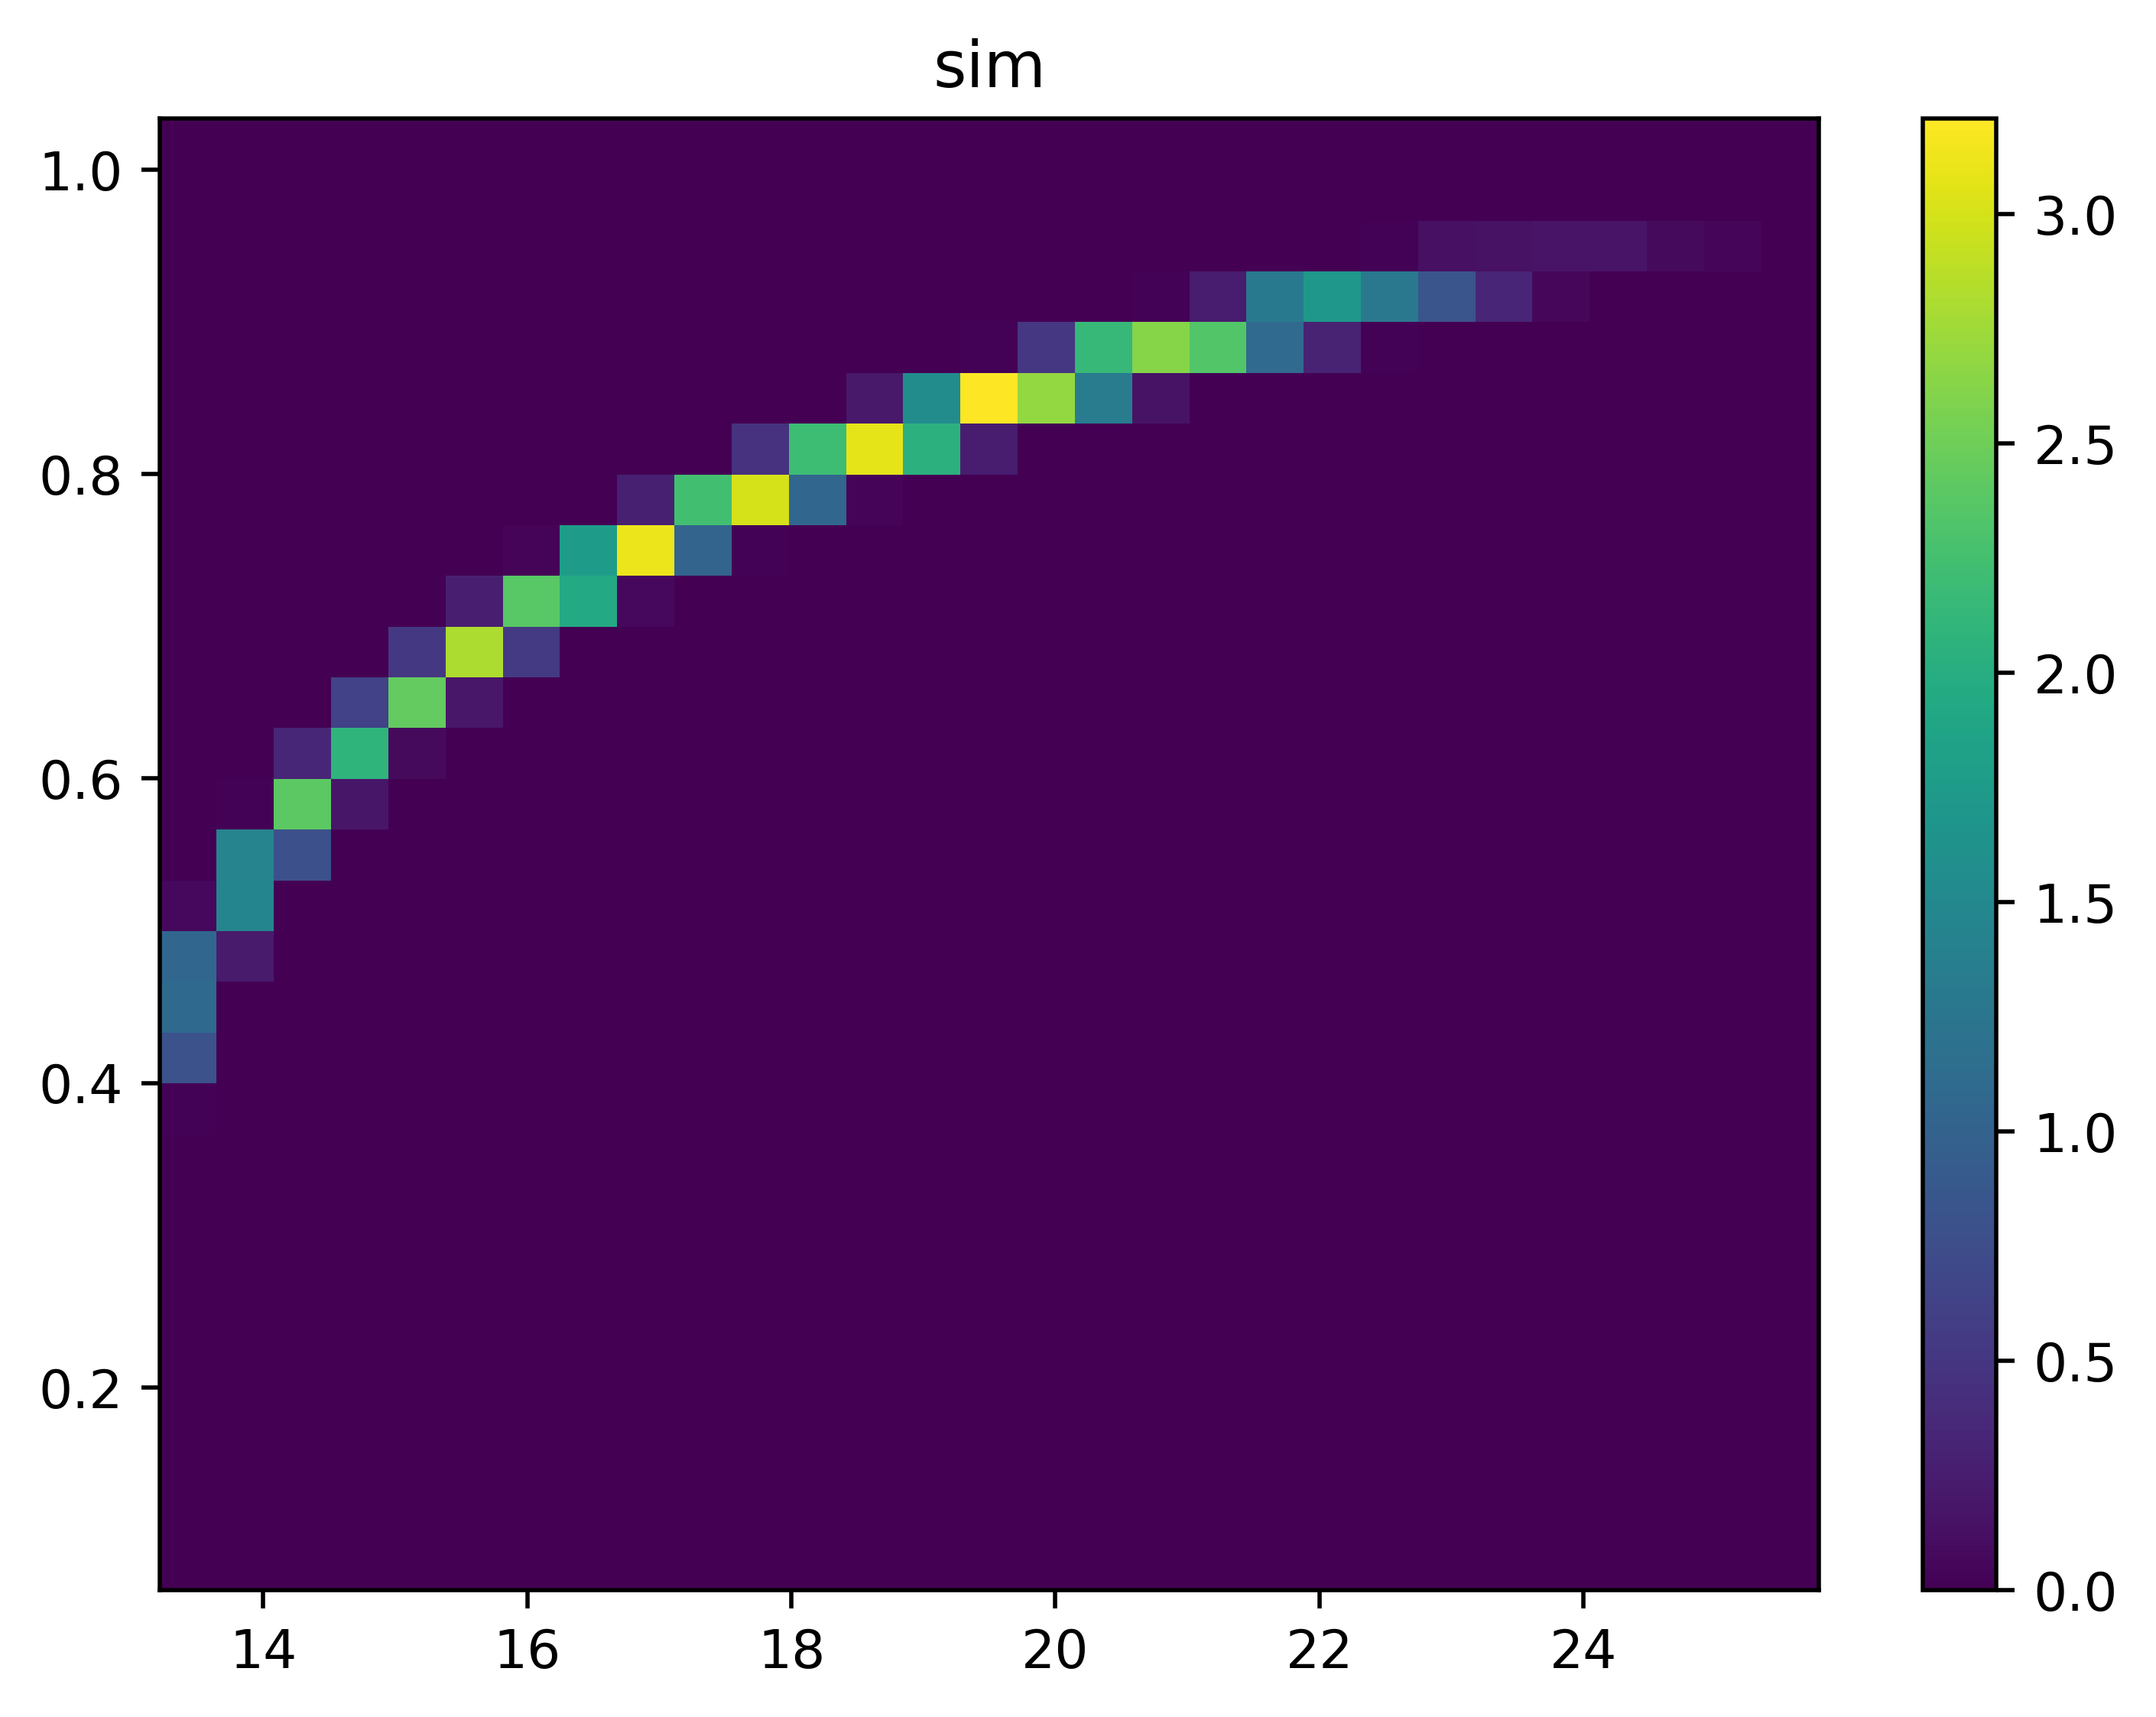

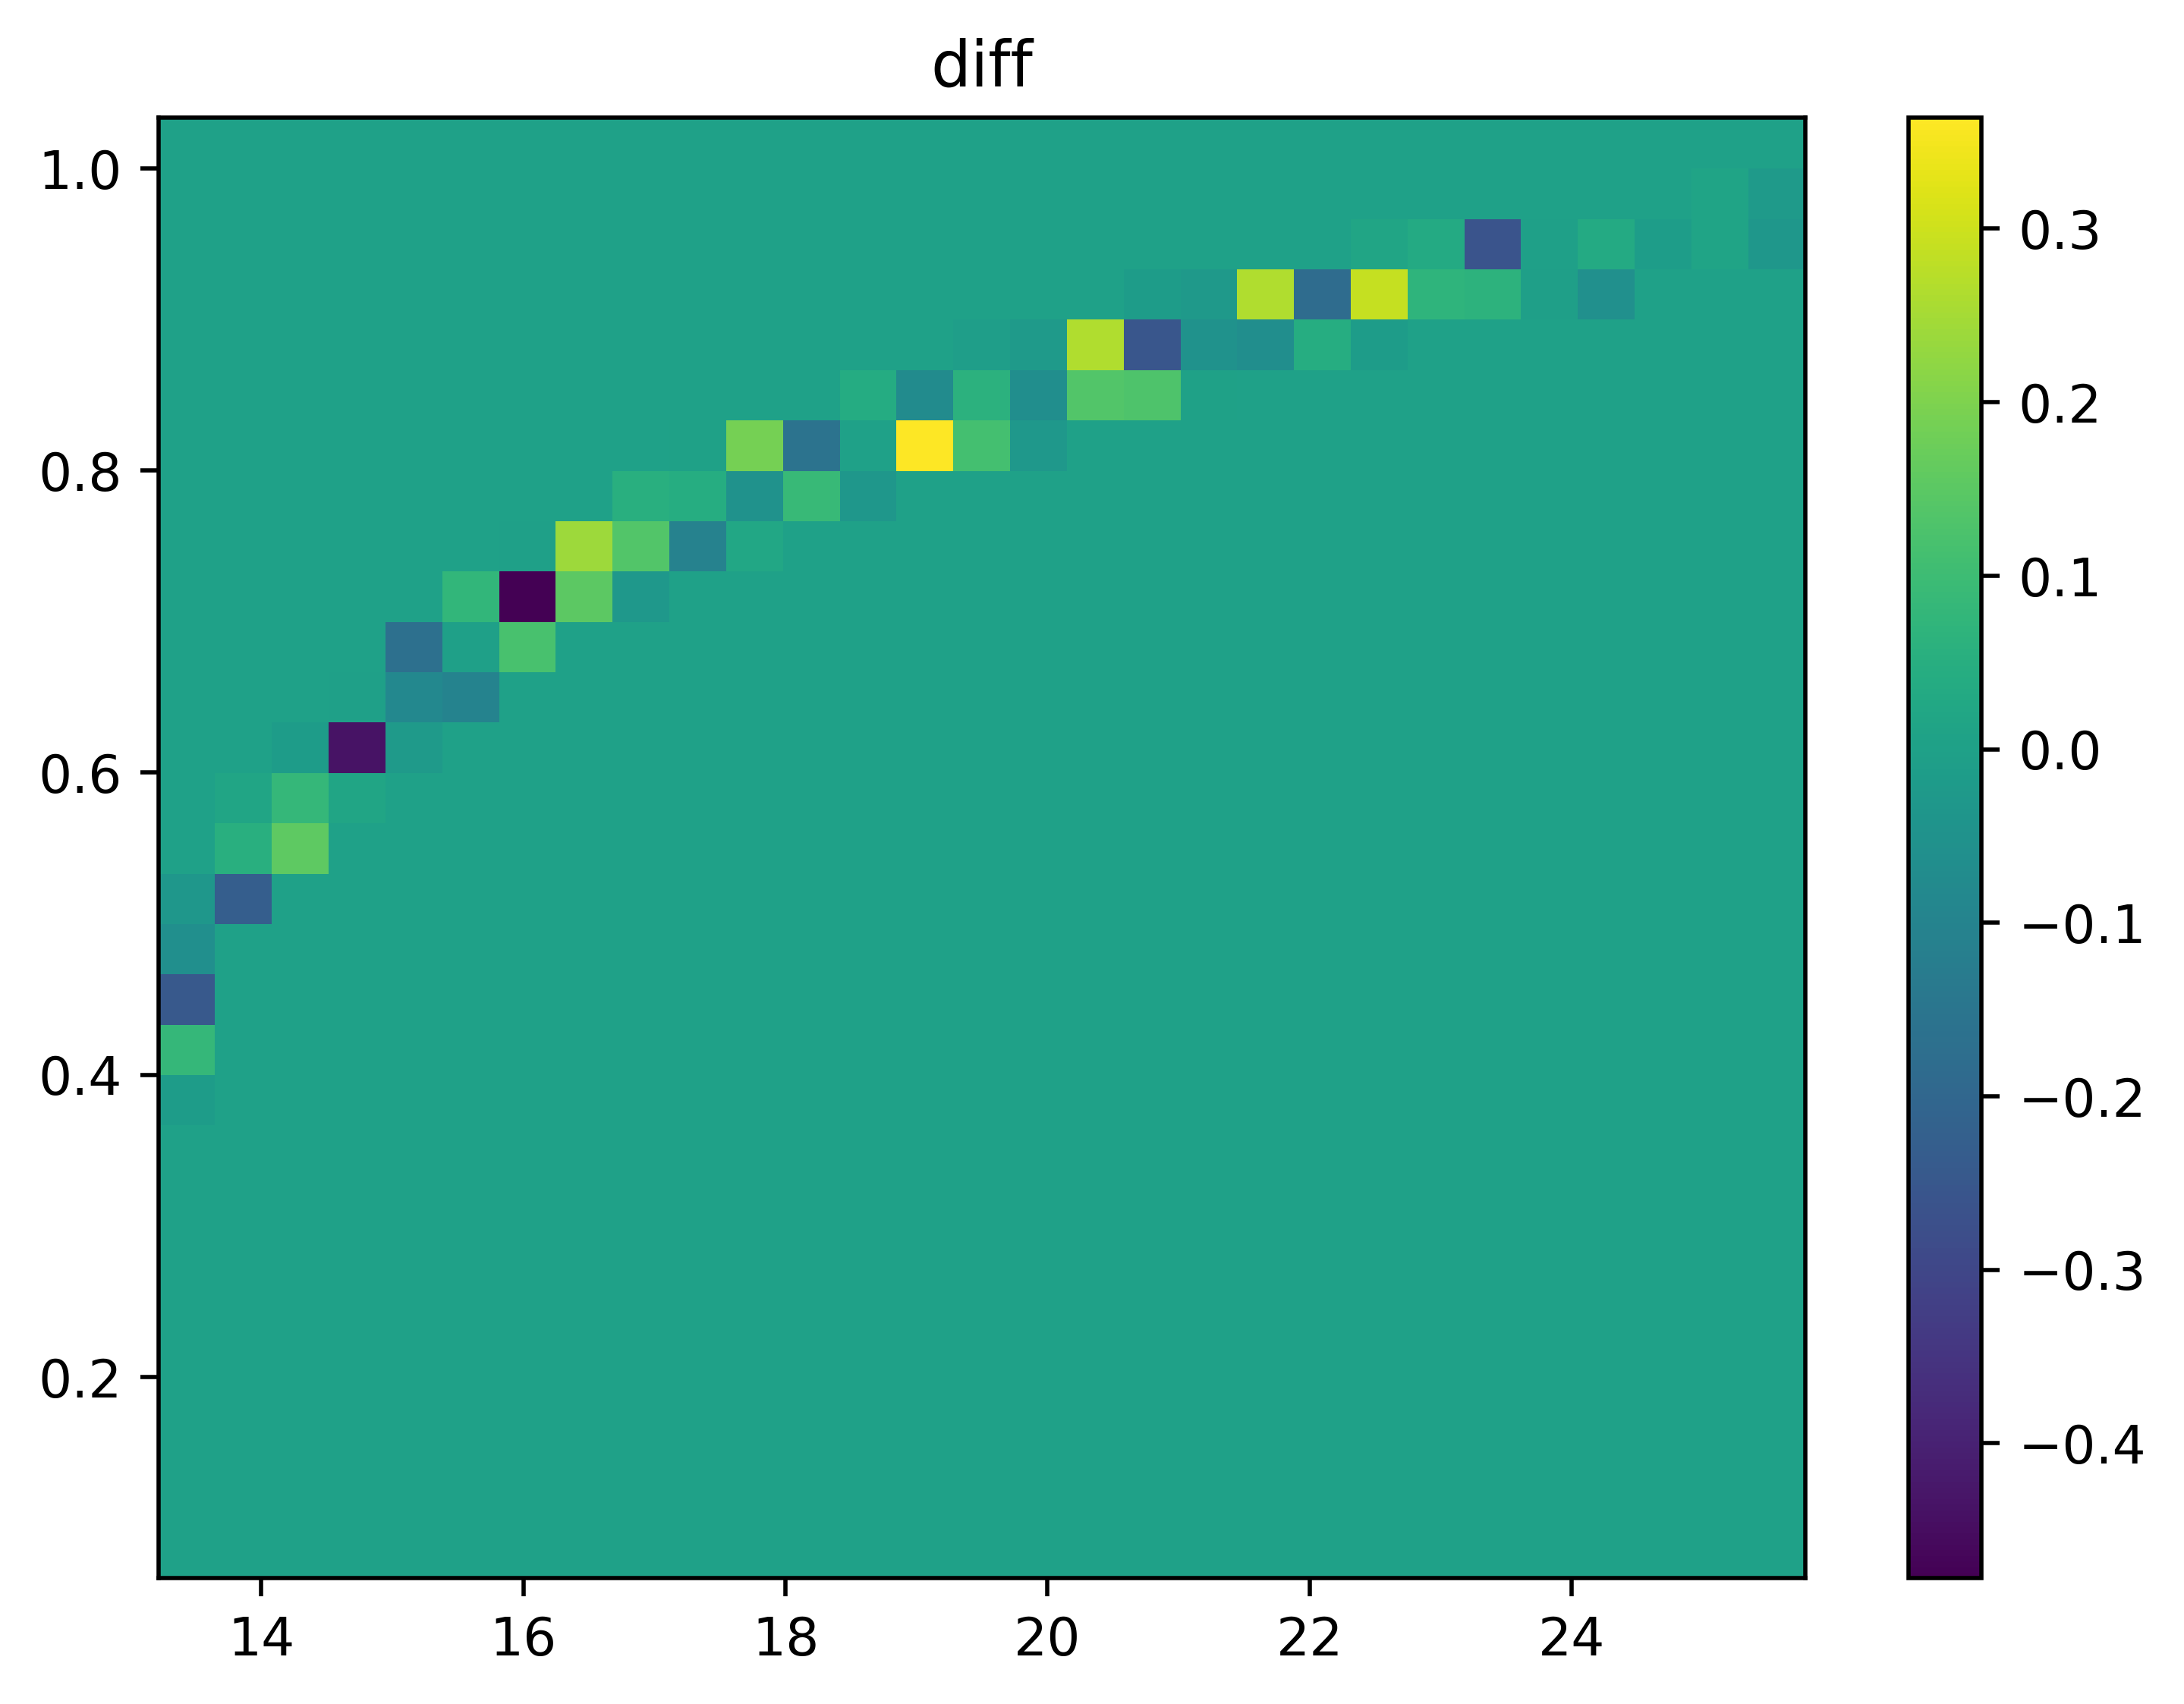

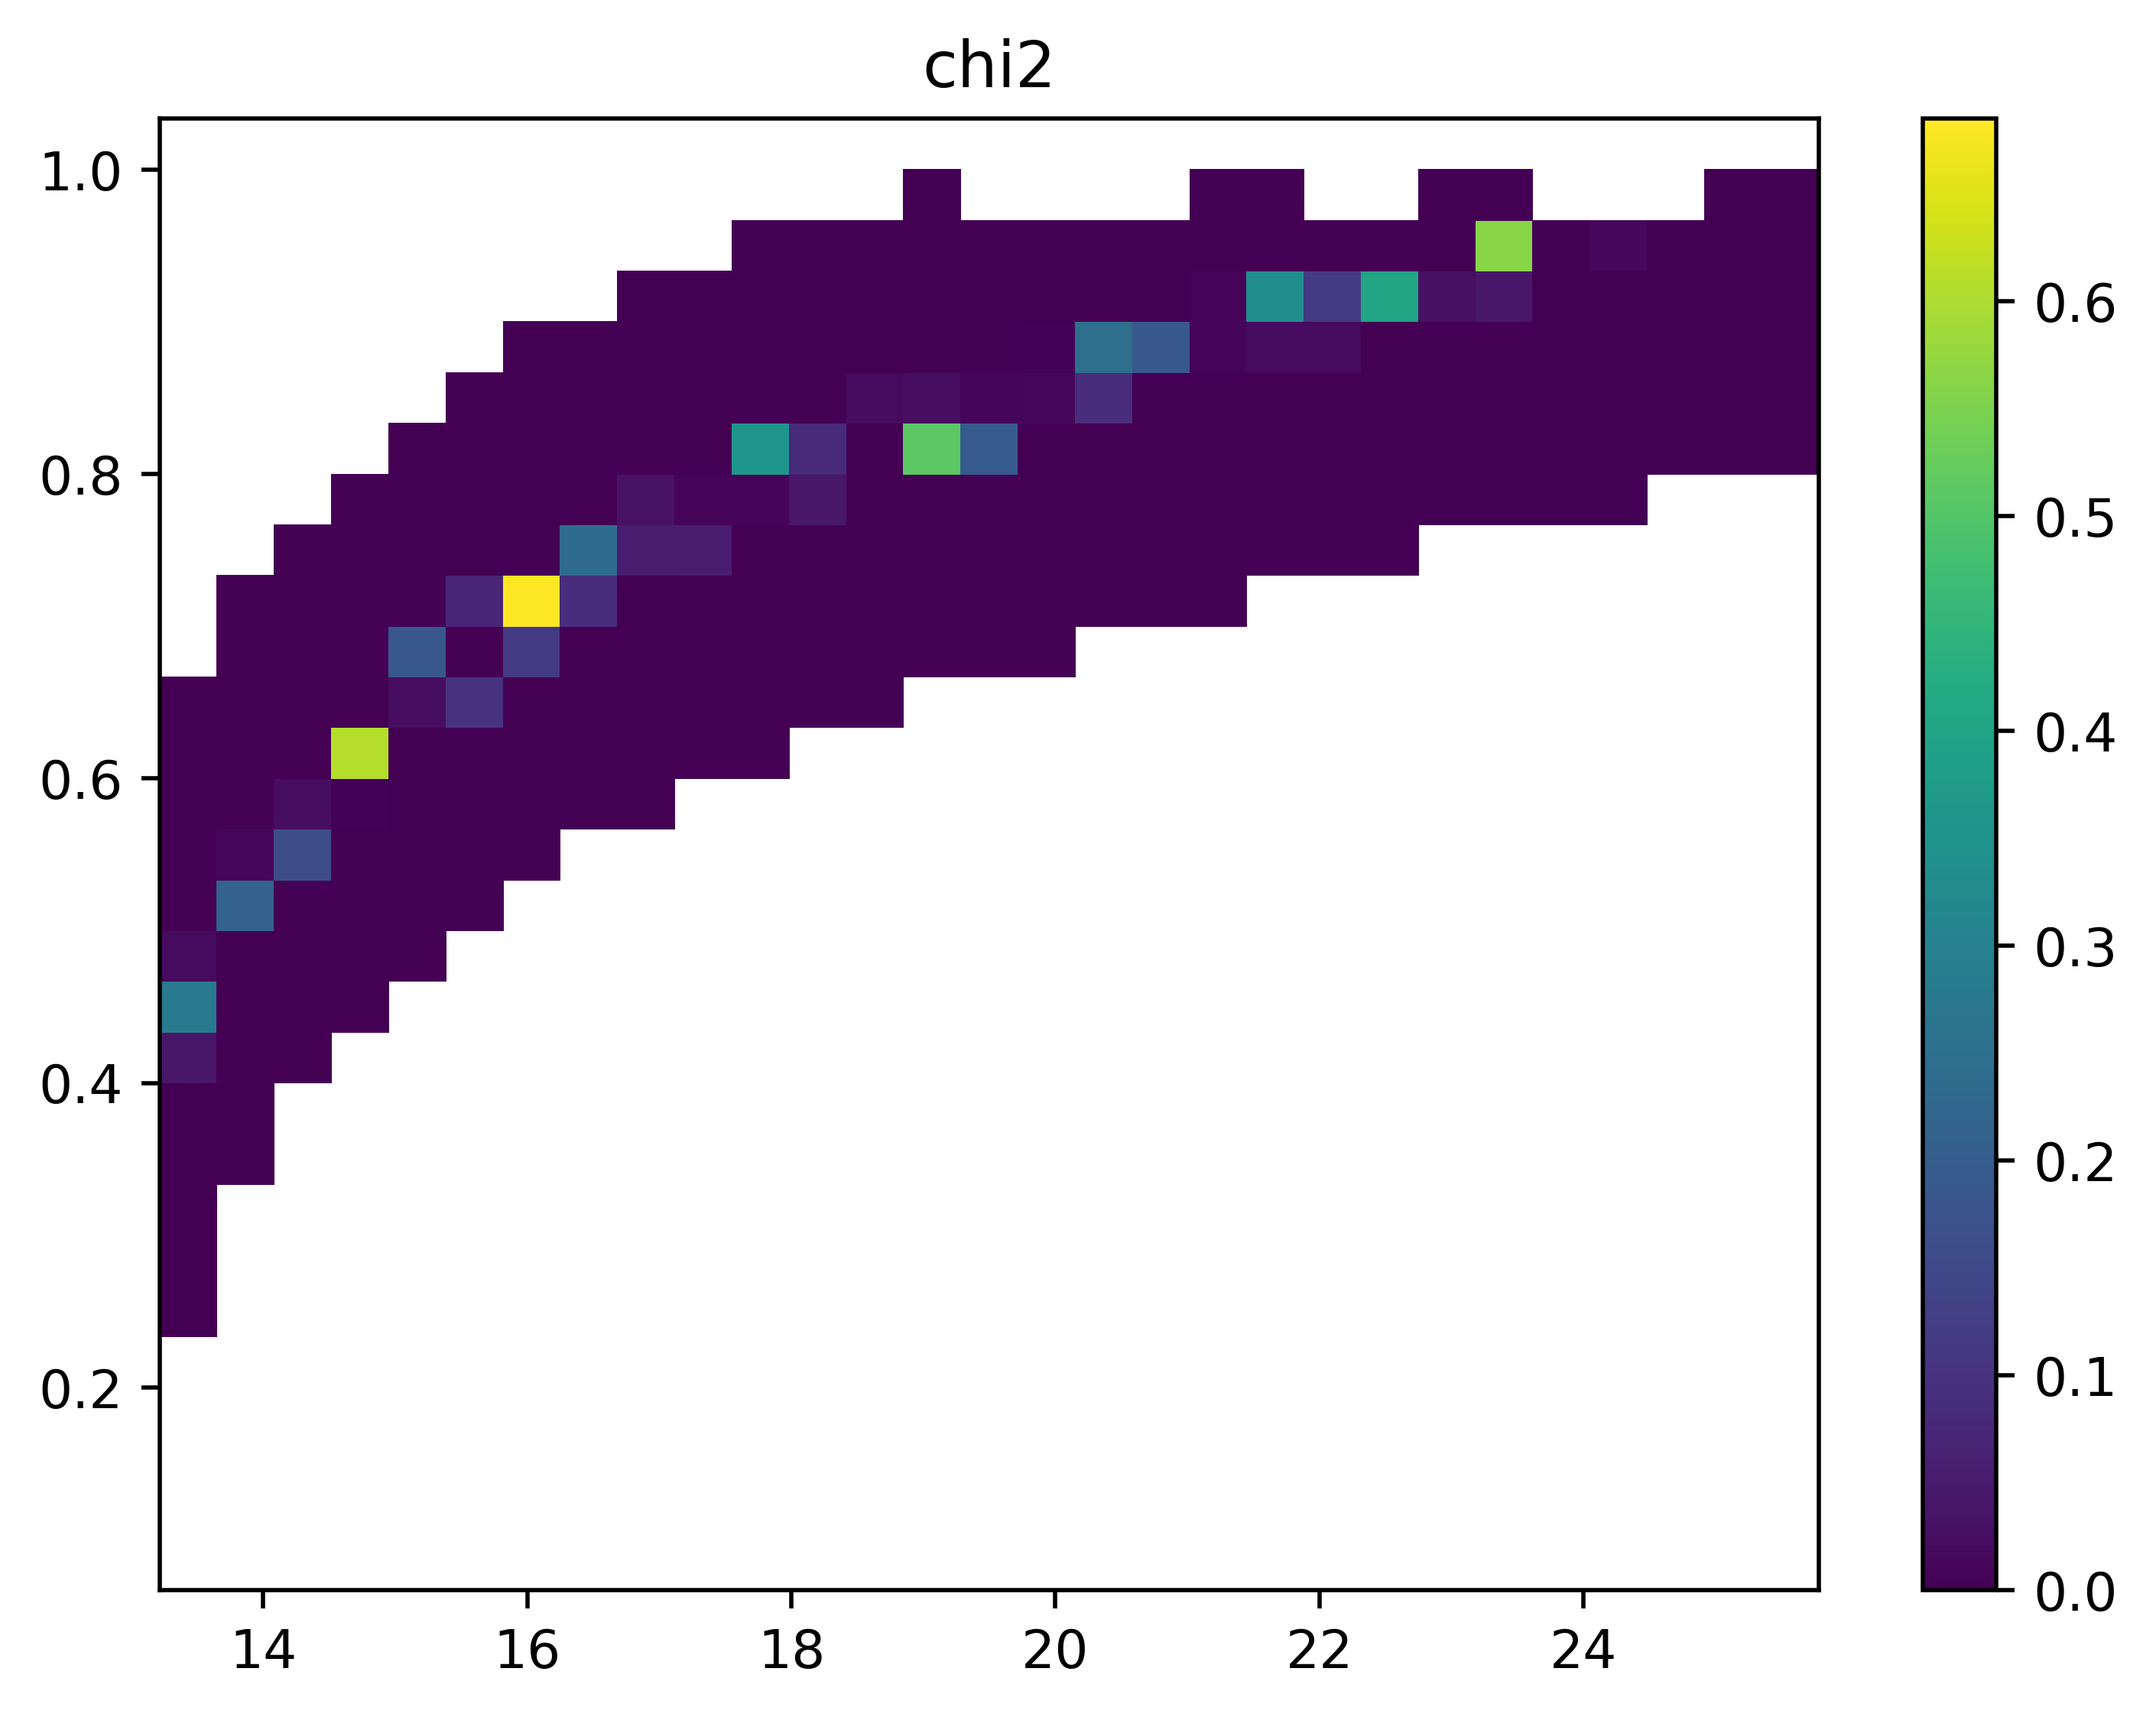

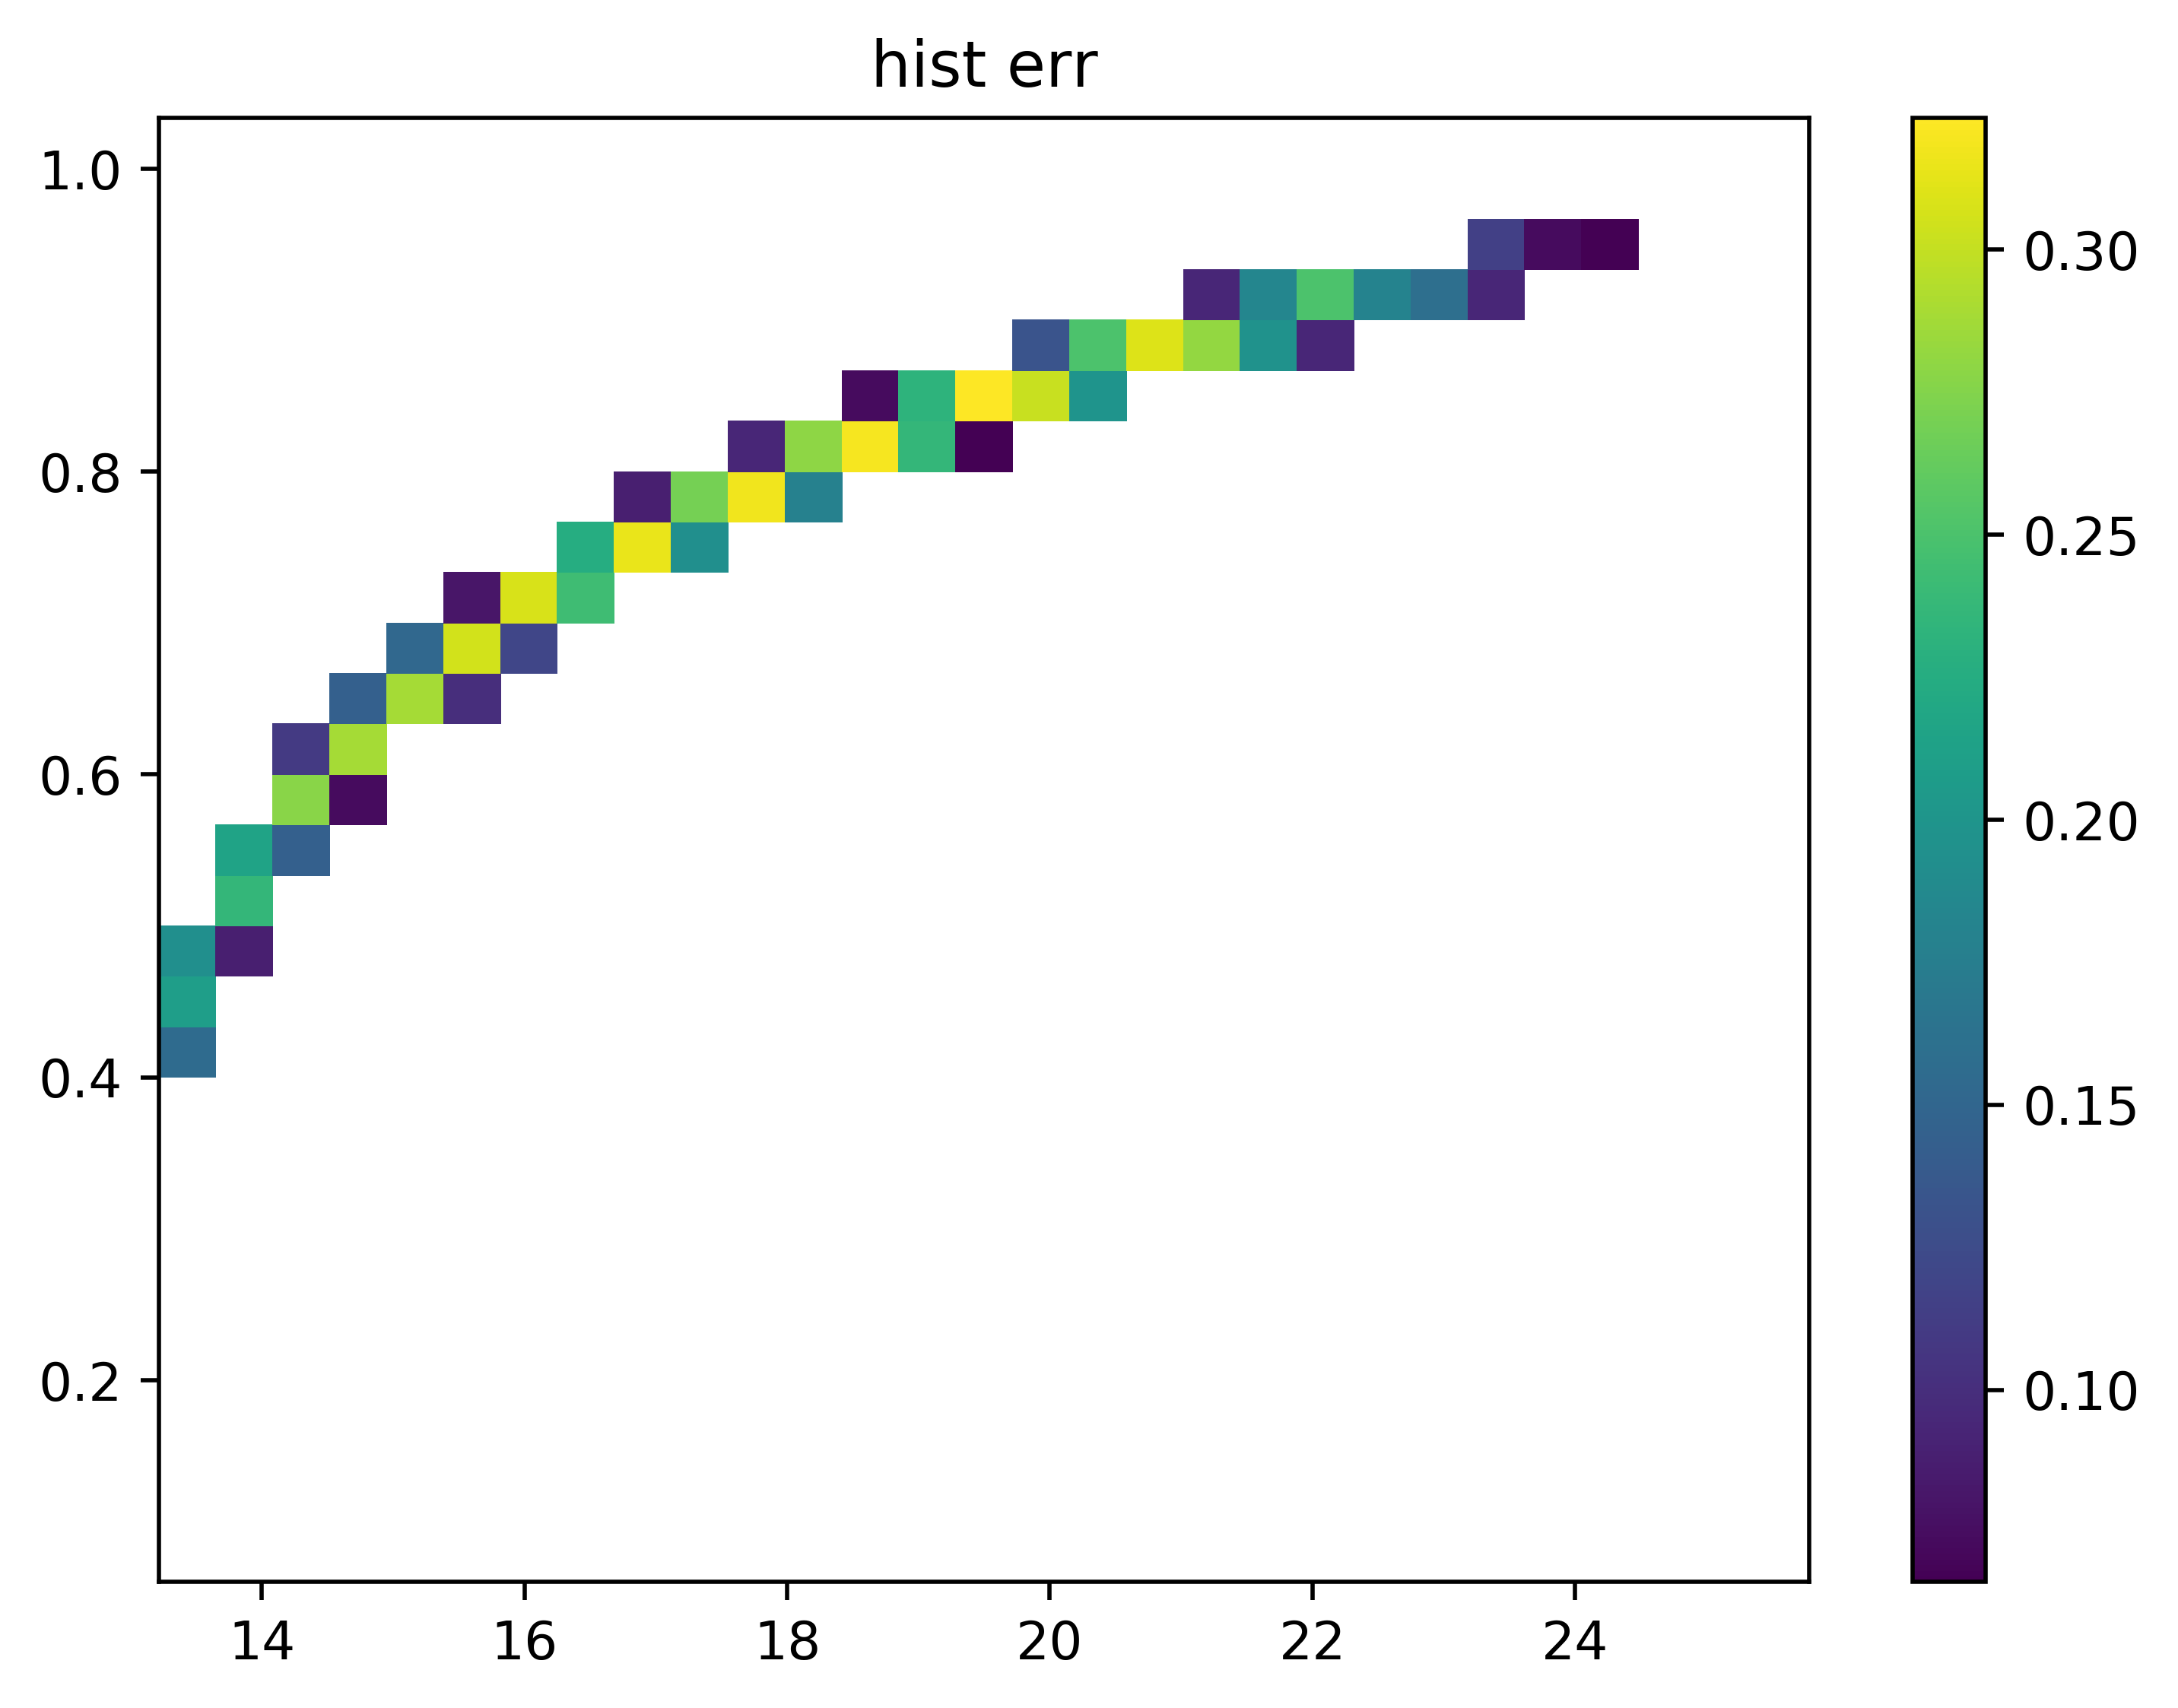

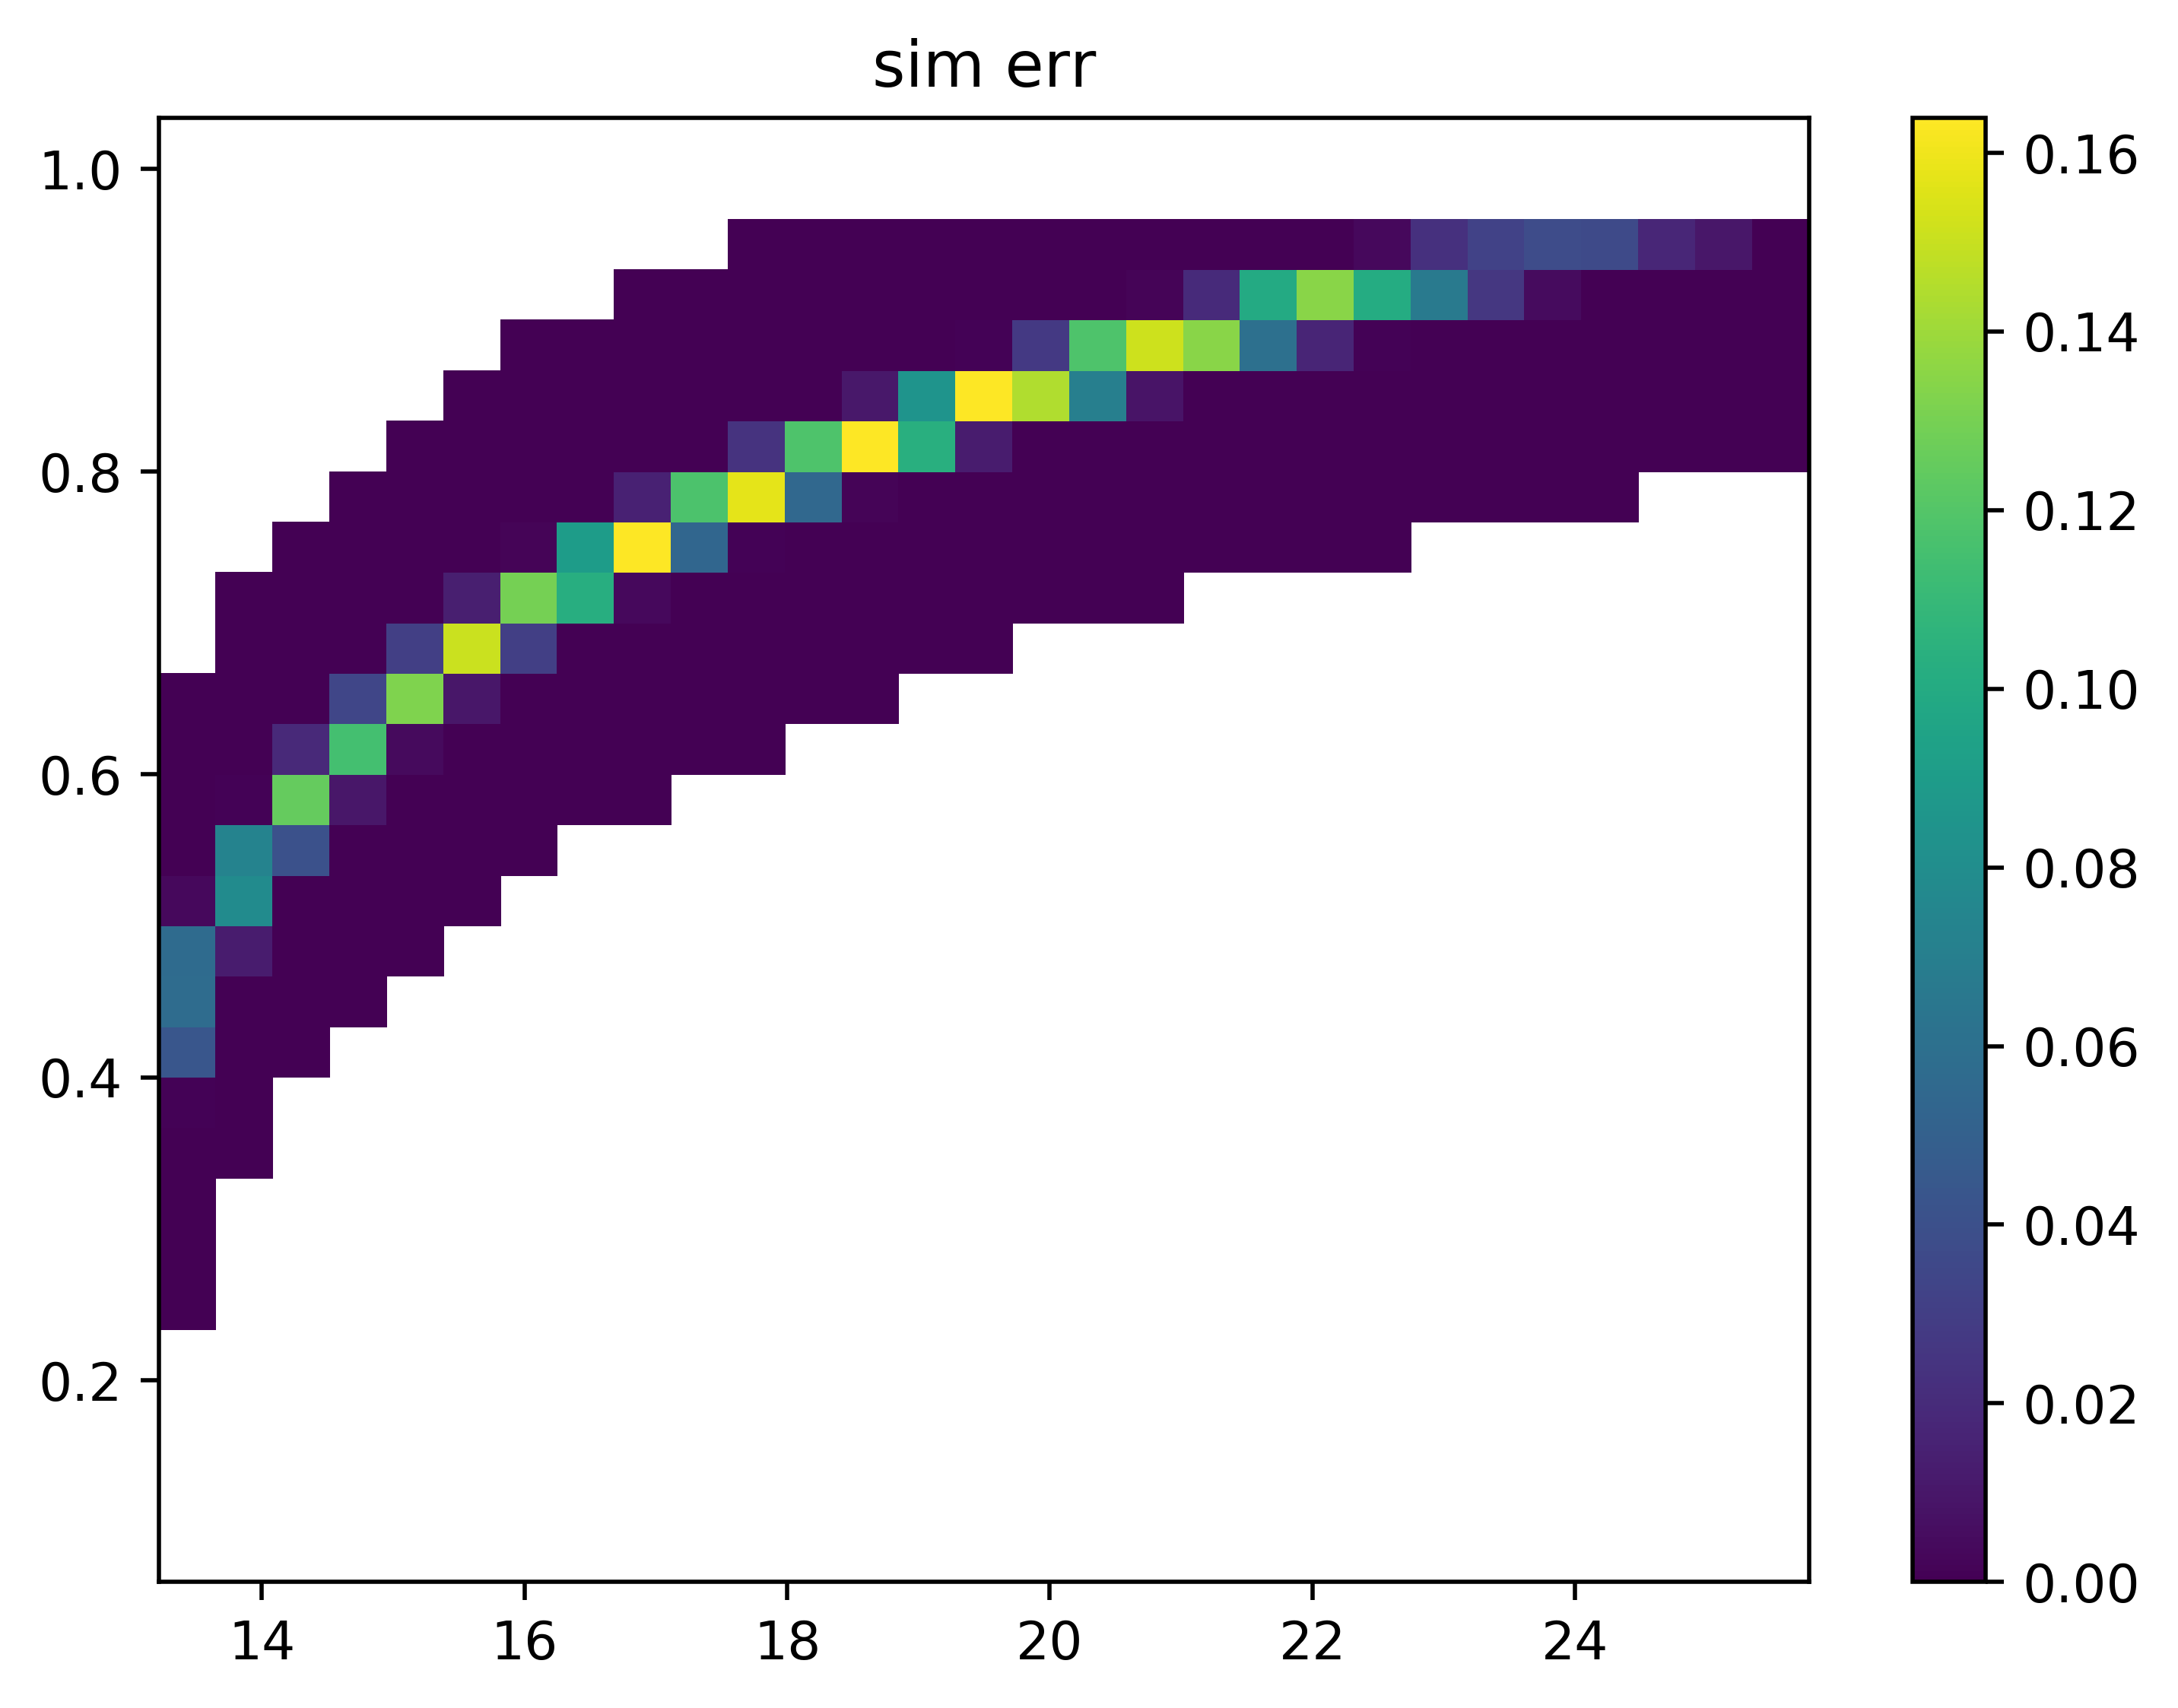

35.156009975387235

In [131]:
get_chi2([0.3, -19.3, 0.1], plot=True)

Lets check a simple minimisation

In [132]:
test_oms, test_MBs = np.meshgrid(np.linspace(0.1, 0.7, 20), np.linspace(-19.3-1, -19.3+1, 20))
test_oms_flat, test_MBs_flat = test_oms.flatten(), test_MBs.flatten()
test_sigma_int = np.ones(test_oms.size) * 0.1
xs = np.vstack((test_oms_flat, test_MBs_flat, test_sigma_int)).T
chi2s = np.array([get_chi2(x) for x in xs]).reshape(test_oms.shape)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


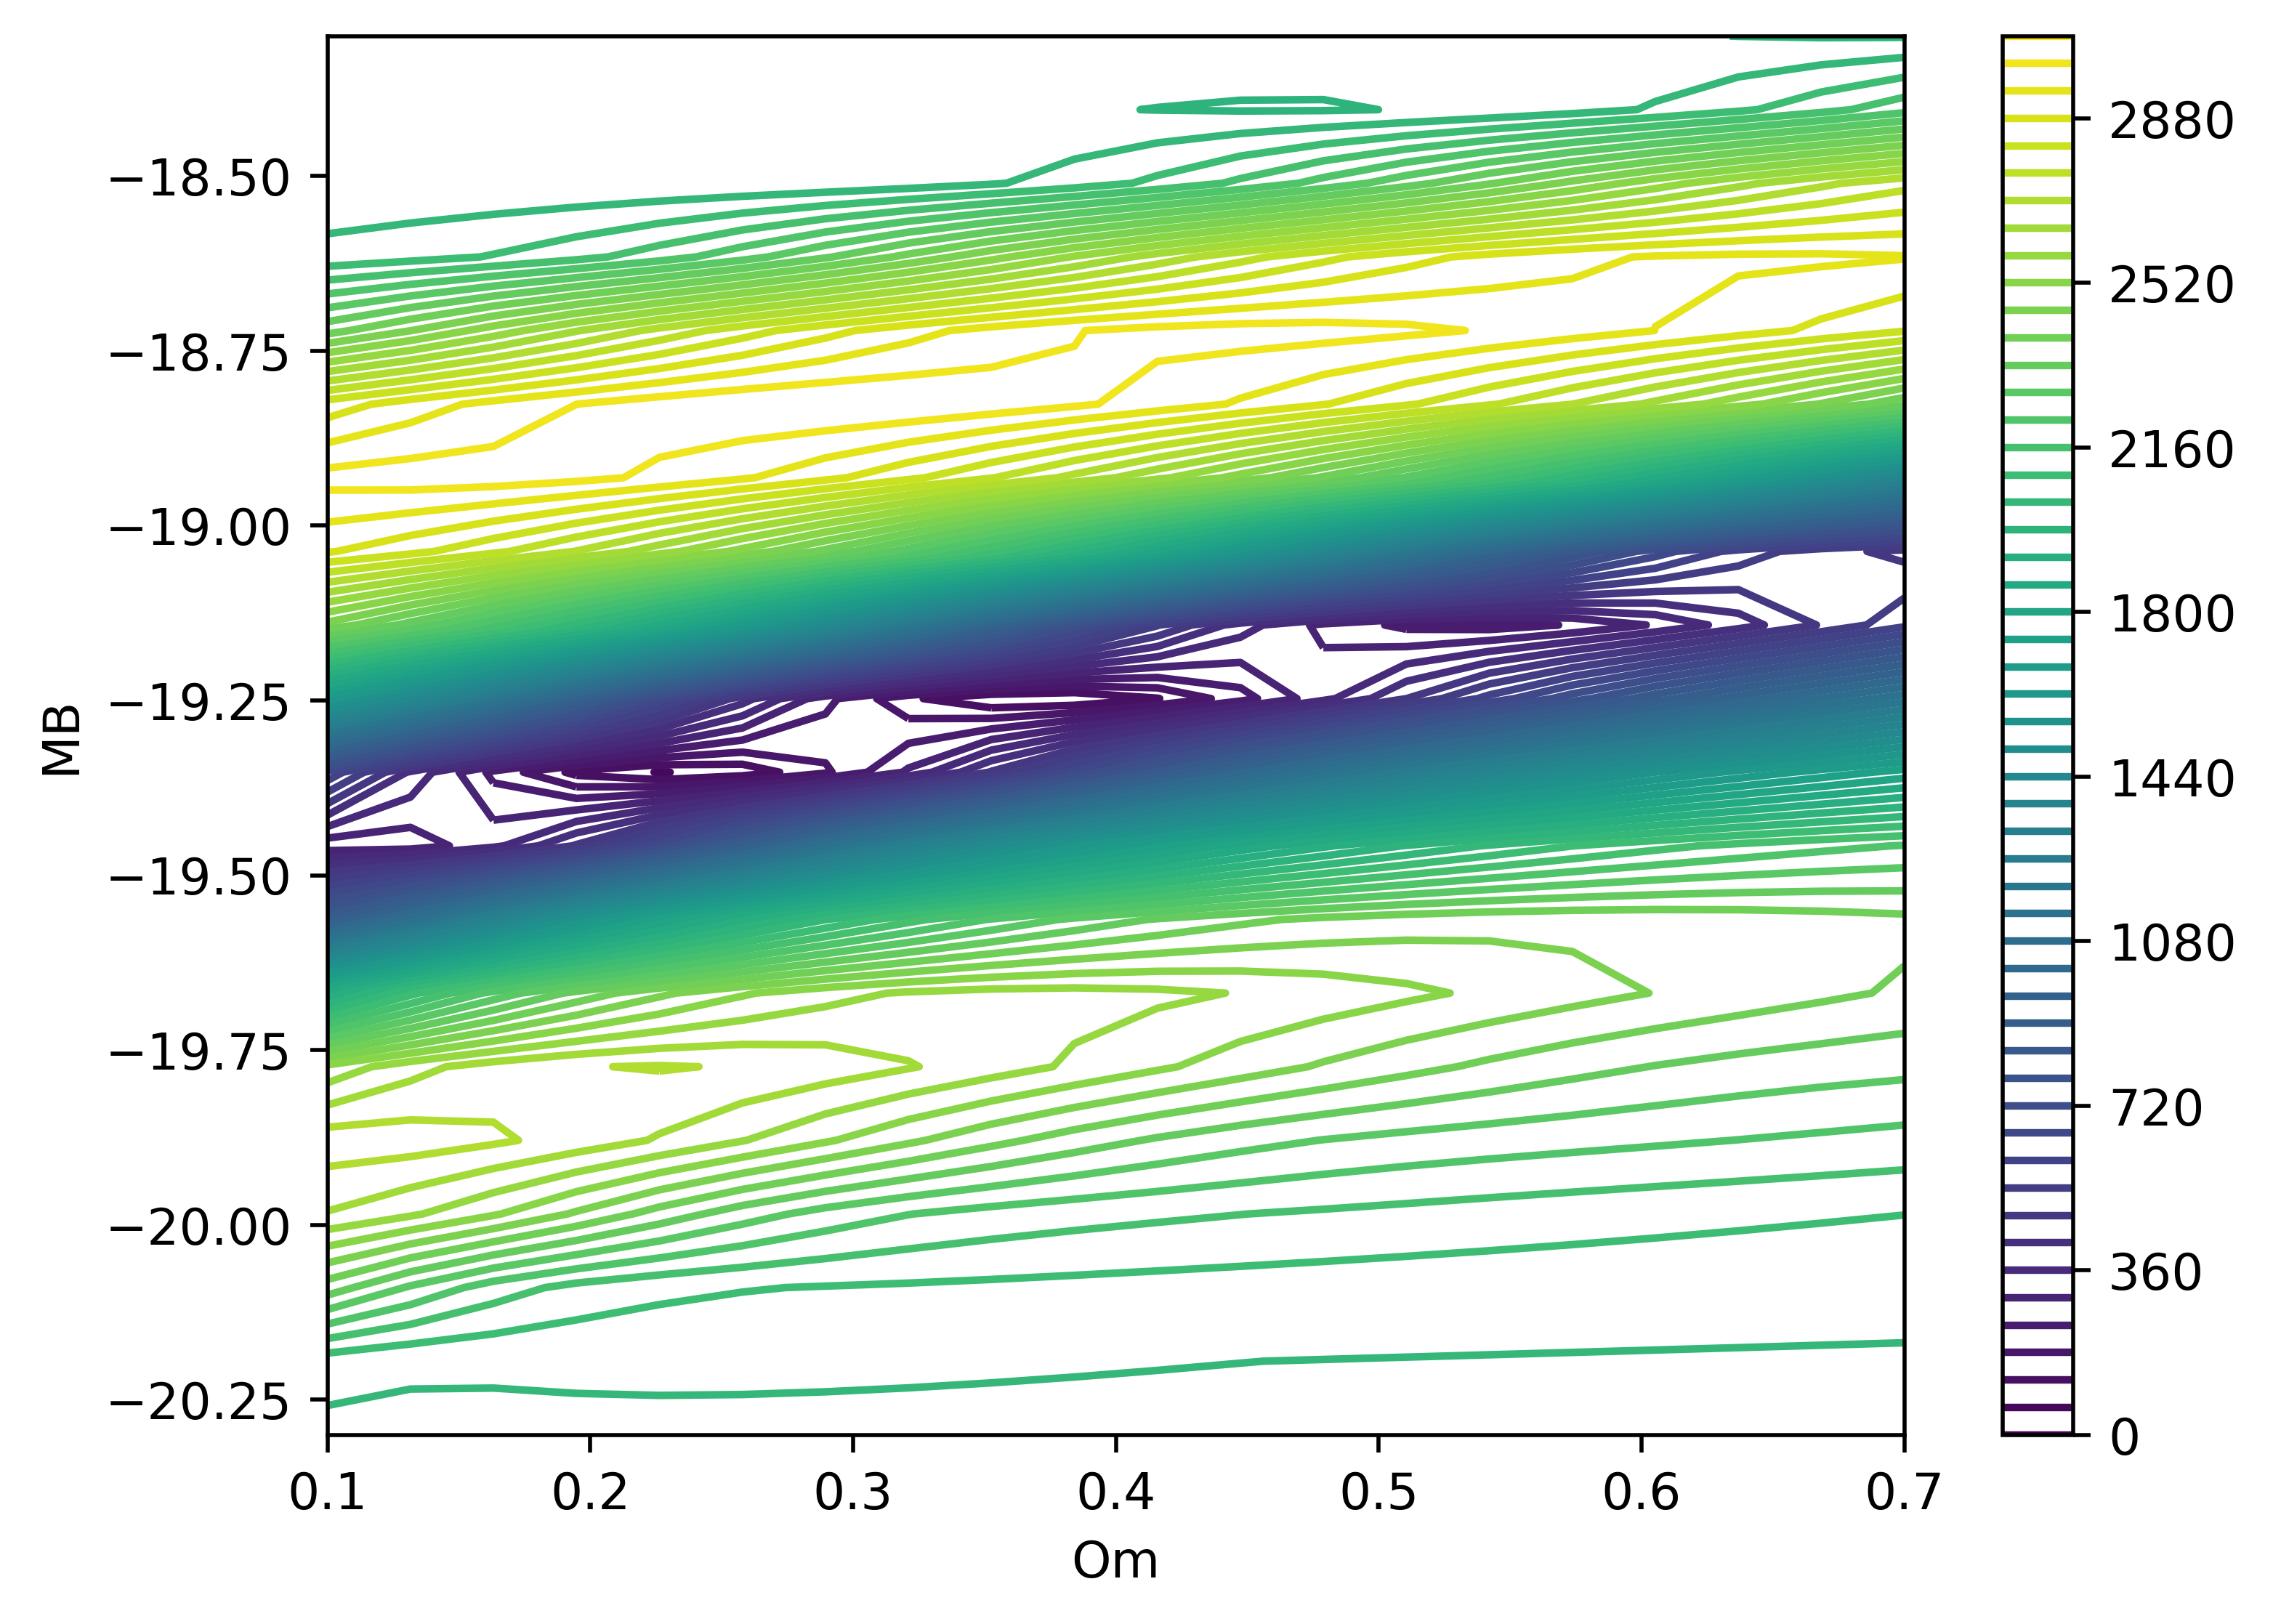

In [133]:
plt.contour(test_oms, test_MBs, chi2s, levels=50)
plt.colorbar(), plt.xlabel("Om"), plt.ylabel("MB");

In [134]:
import emcee
ndim = 3  # How many parameters we are fitting. This is our dimensionality.
nwalkers = 10  # Keep this well above your dimensionality.
p0 = np.random.uniform(low=0.2, high=0.4, size=(nwalkers, ndim))  # Start points
p0[:, 1] += -19
sampler = emcee.EnsembleSampler(nwalkers, ndim, get_log_likelihood)
state = sampler.run_mcmc(p0, 2000)  # Tell each walker to take 4000 steps
chain = sampler.chain[:, 200:, :]  # Throw out the first 200 steps
flat_chain = chain.reshape((-1, ndim))  # Stack the steps from each walker 

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


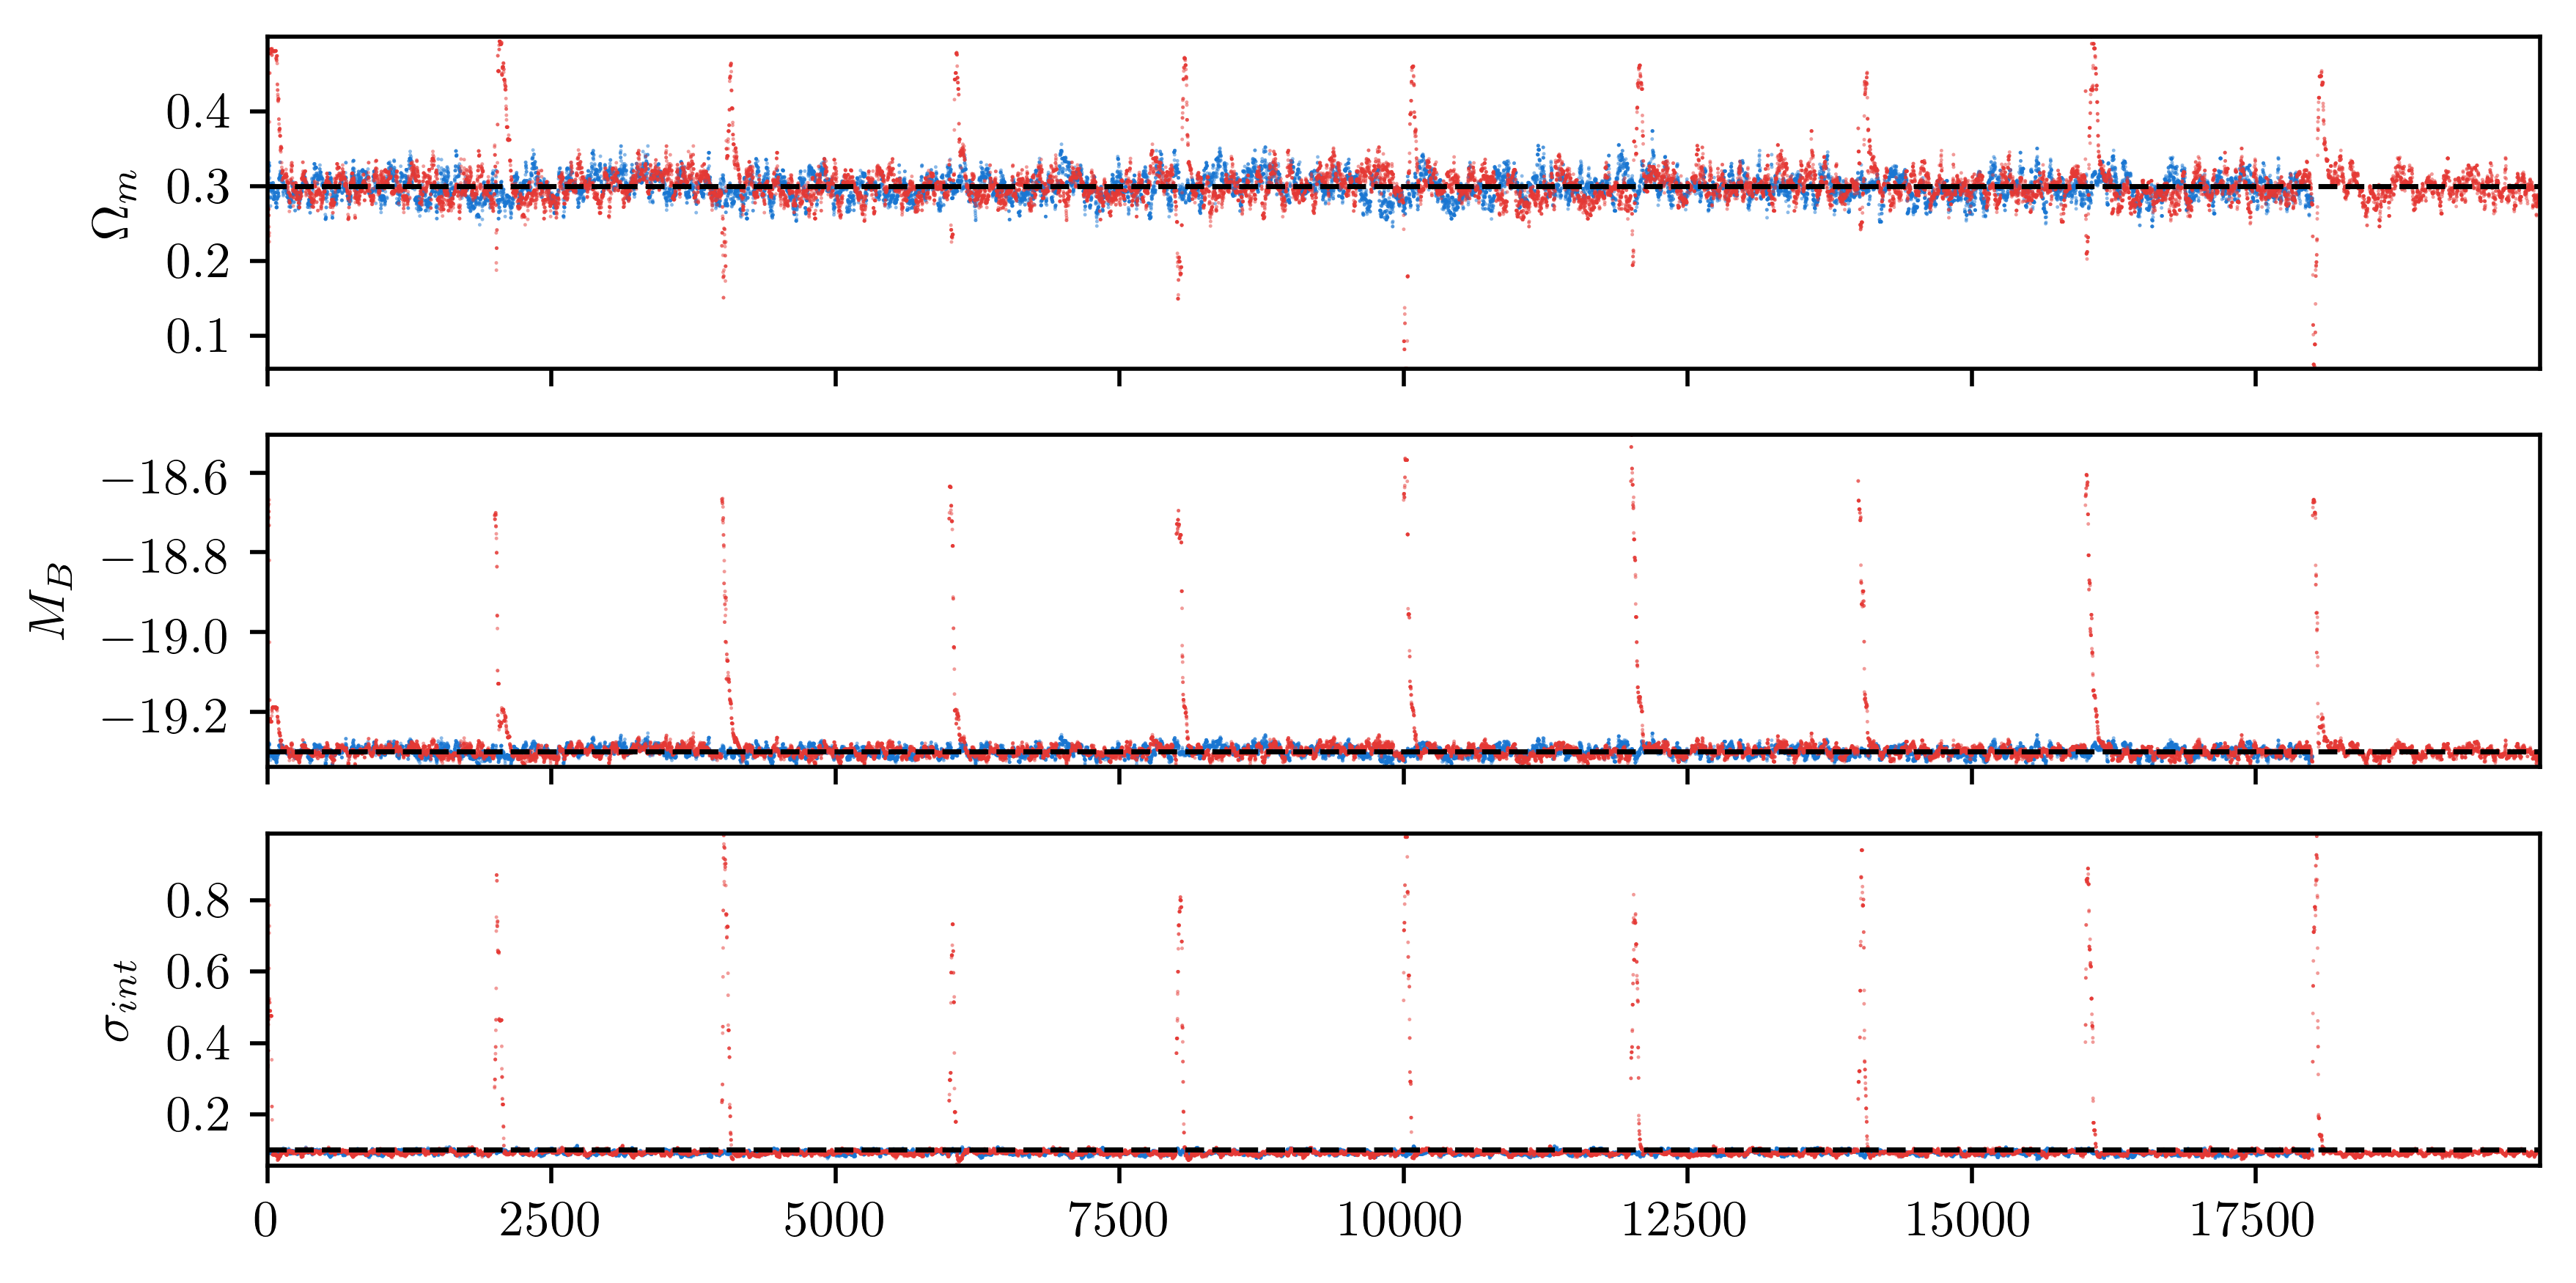

In [135]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain(flat_chain, parameters=[r"$\Omega_m$", "$M_B$", r"$\sigma_{int}$"], color="b")
c.add_chain(sampler.chain.reshape((-1, ndim)), color="r")
c.plotter.plot_walks(truth=[0.3, -19.3, 0.1], figsize=(8,4));

$\Omega_m$ [0.2815472814597334, 0.2947458510272042, 0.3141696825136261]
$M_B$ [-19.3119855494652, -19.2998617993687, -19.288131990754113]
$\sigma_{int}$ [0.0873364123670893, 0.09276985648619926, 0.09725819514738478]


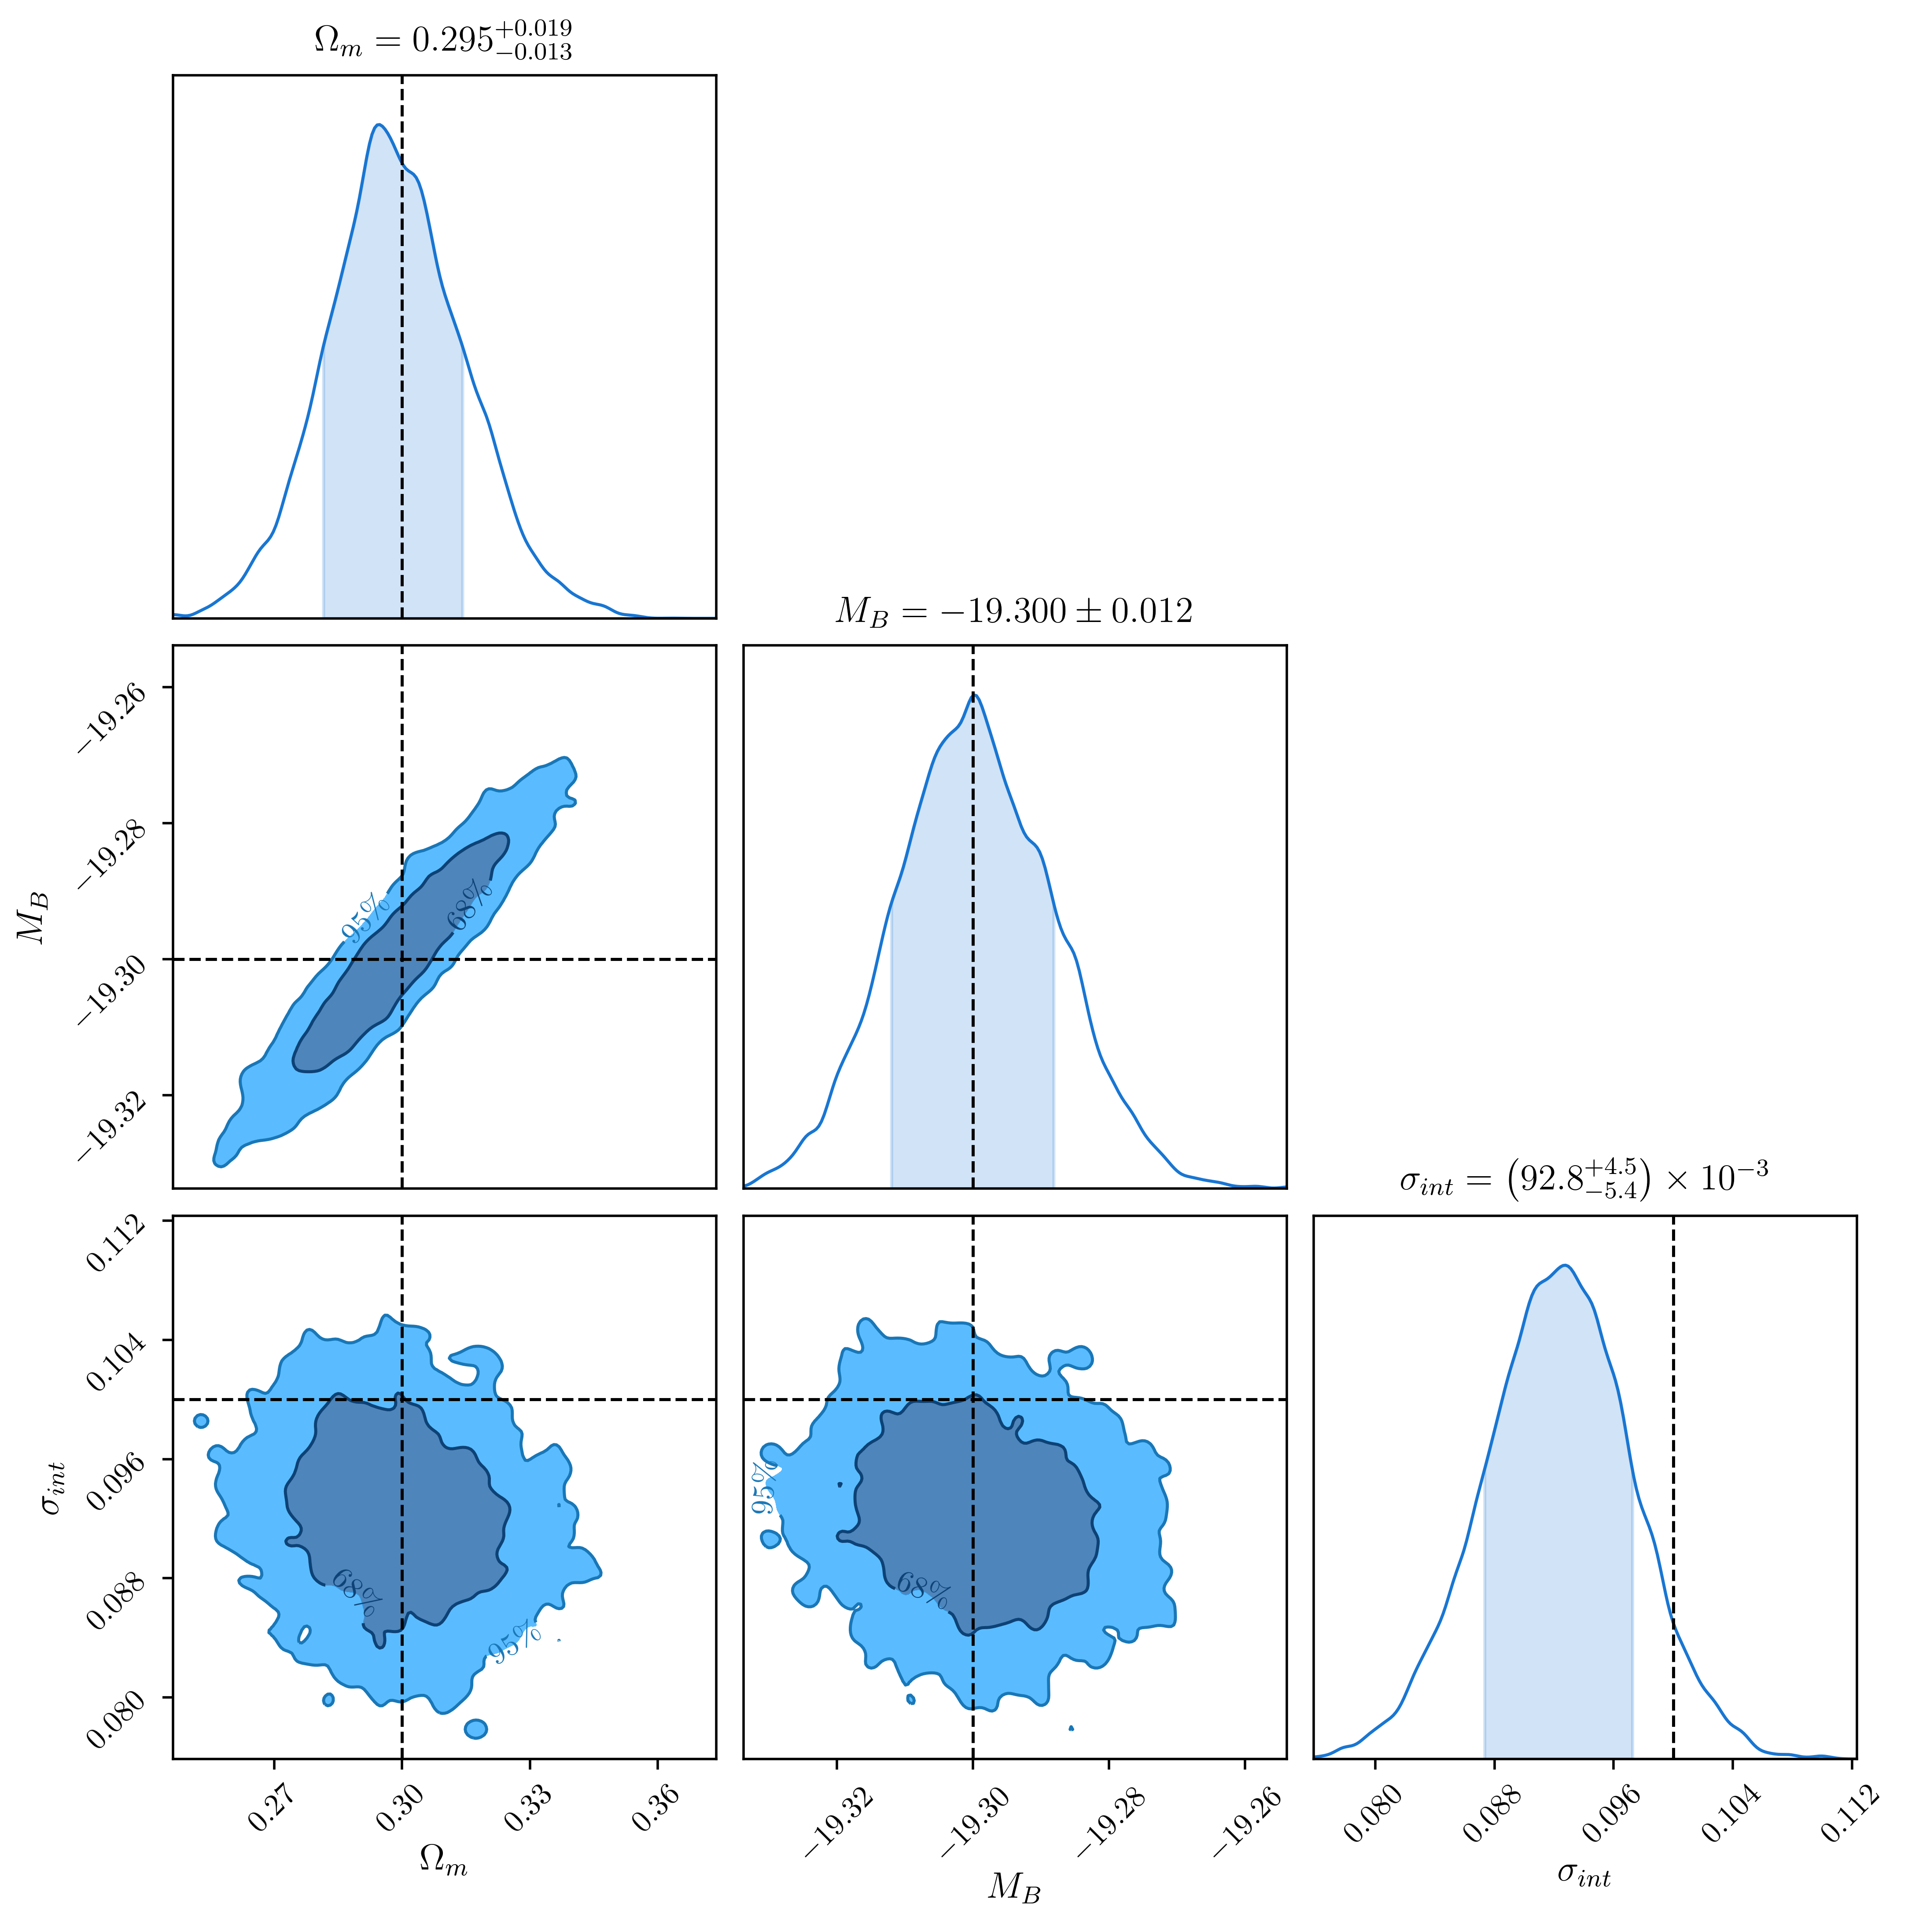

In [136]:
c = ChainConsumer()
c.add_chain(flat_chain, parameters=[r"$\Omega_m$", "$M_B$", r"$\sigma_{int}$"])
c.configure(contour_labels="confidence")
c.plotter.plot(truth=[0.3, -19.3, 0.1], figsize=2.0)
summary = c.analysis.get_summary()
for key, value in summary.items():
    print(key, value)